# Climate data

In [152]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import io
import xarray as xr
import pandas as pd

# method to read the data and aggregate it to a specific region (e.g., Malaysia)
def read_and_aggregate_data(file_path, variable_name):
    
    # Configure boto3 to access the public bucket without signing requests
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    try:
        response = s3.get_object(Bucket='wbg-cckp', Key=file_path)
        data_stream = io.BytesIO(response['Body'].read())
        data = xr.open_dataset(data_stream) # Open the dataset
        subset_data = data.sel(lat=slice(0.85, 7.5), lon=slice(99.6, 119.3)) # Subset the data for the specified latitude and longitude bounds
        
        if variable_name == 'timeseries-pr-monthly-mean':
            aggregated_data = subset_data[variable_name].sum(dim=['lat', 'lon'])
        else:
            aggregated_data = subset_data[variable_name].mean(dim=['lat', 'lon']) # Perform spatial aggregation (e.g., mean)

        df = aggregated_data.to_dataframe().reset_index() # Convert to a DataFrame
        data.close() # Close the dataset
        
        return df
    
    except Exception as e:
        print(f"Error accessing or processing the file: {e}")
        return None

In [11]:
# get histoical data
import pandas as pd
variables = ['pr', 'tas', 'hurs', 'tasmin', 'tasmax', 'sd', 'cdd', 'cwd', 'rxmonth']

historical_climate = pd.DataFrame()
for v in variables:
    url = f'data/cmip6-x0.25/{v}/access-cm2-r1i1p1f1-historical/timeseries-{v}-monthly-mean_cmip6-x0.25_access-cm2-r1i1p1f1-historical_timeseries_mean_1950-2014.nc'
    temp_df = read_and_aggregate_data(url, f'timeseries-{v}-monthly-mean').rename(columns={f'timeseries-{v}-monthly-mean': v})
    
    if historical_climate.empty:
        historical_climate = temp_df[['time', v]]
    else:
        historical_climate[v] = temp_df[v]
        
# split into year and month
historical_climate[['Year', 'Month']] = historical_climate['time'].dt.strftime('%Y-%m').str.split('-', expand=True)
historical_climate[['Year', 'Month']] = historical_climate[['Year', 'Month']].astype(int)
historical_climate = historical_climate[['Year', 'Month', 'pr', 'tas', 'hurs']]

# save to csv
# historical_climate.to_csv('historical_climate_v2.csv', index=False)
print('historical_climate_v2.csv saved')

historical_climate_v2.csv saved


In [ ]:
import pandas as pd
vars = ['cdd', 'cwd', 'sd', 'rxmonth']

def create_dataframe(v):
  base_url = f"data/cmip6-x0.25/{v}/access-cm2-r1i1p1f1-historical/timeseries-{v}-monthly-mean_cmip6-x0.25_access-cm2-r1i1p1f1-historical_timeseries_mean_1950-2014.nc"
  variable = f"timeseries-{v}-monthly-mean"
  data = read_and_aggregate_data(base_url, variable)

  return data

cdd = create_dataframe('cdd')
cwd = create_dataframe('cwd')
sd = create_dataframe('sd')

In [ ]:
data = pd.merge(cdd, cwd, on=['time'])
data = pd.merge(data, sd, on=['time'])
data.rename(columns={'timeseries-cdd-monthly-mean': 'cdd', 'timeseries-cwd-monthly-mean': 'cwd', 'timeseries-sd-monthly-mean': 'sd'}, inplace=True)
# convert values form days and hours into float
data['cdd'] = data['cdd'].dt.total_seconds() / (60*60*24) # Convert Timedelta to days 
data['cwd'] = data['cwd'].dt.total_seconds() / (60*60*24) # Convert Timedelta to days
data['sd'] = data['sd'].dt.total_seconds() / (60*60*24) # Convert Timedelta to days
data.to_csv('cdd_cwd_sd.csv', index=False)

In [ ]:
url = "data/cmip6-x0.25/tasmax/access-cm2-r1i1p1f1-historical/timeseries-tasmax-seasonal-mean_cmip6-x0.25_access-cm2-r1i1p1f1-historical_timeseries_mean_1950-2014.nc"

temp_df = read_and_aggregate_data(url, 'timeseries-tasmax-monthly-mean')
temp_df

Error accessing or processing the file: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.


In [ ]:
# get histoical data
import pandas as pd
variables = ['tasmin', 'tasmax']

pr_tas_husr = pd.read_csv('historical_climate.csv')
historical_climate = pd.DataFrame()
for v in variables:
    url = f'data/cmip6-x0.25/{v}/access-cm2-r1i1p1f1-historical/timeseries-{v}-monthly-mean_cmip6-x0.25_access-cm2-r1i1p1f1-historical_timeseries_mean_1950-2014.nc'
    temp_df = read_and_aggregate_data(url, f'timeseries-{v}-monthly-mean')
    
    if historical_climate.empty:
        historical_climate = temp_df[['time', v]]
    else:
        historical_climate[v] = temp_df[v]
        
# split into year and month
historical_climate[['Year', 'Month']] = historical_climate['time'].dt.strftime('%Y-%m').str.split('-', expand=True)
historical_climate[['Year', 'Month']] = historical_climate[['Year', 'Month']].astype(int)
historical_climate = historical_climate[['Year', 'Month', 'tasmin', 'tasmax']]
historical_climate = pd.merge(pr_tas_husr, historical_climate, on=['Year', 'Month'])
historical_climate = historical_climate[['Year', 'Month', 'pr', 'tas', 'hurs', 'tasmin', 'tasmax']]
historical_climate

# save to csv
# historical_climate.to_csv('historical_climate_v2.csv', index=False)
# print('historical_climate_v2.csv saved')

In [44]:
historical_climate = pd.read_csv('historical_climate_v2.csv')
cdd_cwd_sd = pd.read_csv('cdd_cwd_sd.csv')
historical_climate = pd.merge(historical_climate, cdd_cwd_sd, on=['Year', 'Month'])
historical_climate.to_csv('historical_climate_v3.csv', index=False)

In [154]:
# get Shared Socioeconomic Pathways (SSP) projection data
ssp = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
variables = ['pr', 'tas', 'hurs', 'tasmin', 'tasmax']

# cycle to the links and download the data
for s in ssp:
    climate_df = pd.DataFrame()
    
    for v in variables:
        url = f"data/cmip6-x0.25/{v}/access-cm2-r1i1p1f1-{s}/timeseries-{v}-monthly-mean_cmip6-x0.25_access-cm2-r1i1p1f1-{s}_timeseries_mean_2015-2100.nc"
        temp_df = read_and_aggregate_data(url, f'timeseries-{v}-monthly-mean').rename(columns={f'timeseries-{v}-monthly-mean': v})
        
        if climate_df.empty: # if dataframe is empty, assign the first variable
            climate_df = temp_df[['time', v]]
        else:
            climate_df[v] = temp_df[v]
            
    # split into year and month
    climate_df[['Year', 'Month']] = climate_df['time'].dt.strftime('%Y-%m').str.split('-', expand=True)
    climate_df[['Year', 'Month']] = climate_df[['Year', 'Month']].astype(int)
    climate_df = climate_df[['Year', 'Month', 'pr', 'tas', 'hurs', 'tasmin', 'tasmax']]
    
    # save the data to csv
    climate_df.to_csv(f'{s}_climate2.csv', index=False)
    print(f'{s}_climate2.csv saved')

ssp126_climate2.csv saved
ssp245_climate2.csv saved
ssp370_climate2.csv saved
ssp585_climate2.csv saved


# Palm oil data from MPOB

Fresh Fruit Bunches Yield 

In [111]:
import pandas as pd

# Get Fresh Fruit Bunch (FFB) Yield data
ffb = pd.read_excel('Malaysia Monthly FFB Yield, CPO Yield and FFB Production.xlsx', sheet_name= 'FFB Yield (Malaysia)', skiprows=3)
ffb = ffb.drop(columns='Unnamed: 0', index=[12,13,14])
ffb = pd.melt(ffb, id_vars=['YEAR\nMONTH'], var_name='Year', value_name='FFB_Yield')
ffb = ffb.rename(columns={'YEAR\nMONTH': 'Month'})
ffb = ffb[['Year', 'Month', 'FFB_Yield']]
ffb['Month'] = pd.to_datetime(ffb['Month'], format='%B').dt.month

# Get Crude Palm Oil (CPO) Yield data
cpo = pd.read_excel('Malaysia Monthly FFB Yield, CPO Yield and FFB Production.xlsx', sheet_name= 'CPO Yield (Malaysia)', skiprows=3)
cpo = cpo.drop(columns='Unnamed: 0', index=[12,13,14])
cpo = pd.melt(cpo, id_vars=['YEAR\nMONTH'], var_name='Year', value_name='CPO_Yield')
cpo = cpo.rename(columns={'YEAR\nMONTH': 'Month'})
cpo = cpo[['Year', 'Month', 'CPO_Yield']]
cpo['Month'] = pd.to_datetime(cpo['Month'], format='%B').dt.month

# Get Fresh Fruit Bunch (FFB) Production data
ffb2 = pd.read_excel('Malaysia Monthly FFB Yield, CPO Yield and FFB Production.xlsx', sheet_name= 'FFB Production', skiprows=4)
ffb2 = ffb2.drop(columns='Unnamed: 0', index=[12,13])
ffb2 = pd.melt(ffb2, id_vars=['Bulan'], var_name='Year', value_name='FFB_production')
ffb2 = ffb2.rename(columns={'Bulan': 'Month'})
ffb2 = ffb2[['Year', 'Month', 'FFB_production']]
month_mapping = {
    "Jan": 1, "Feb": 2, "Mac": 3, "Apr": 4, "Mei": 5, "Jun": 6, 
    "Jul": 7, "Ogo": 8, "Sep": 9, "Okt": 10, "Nov": 11, "Dis": 12
} # mapping months
ffb2['Month'] = ffb2['Month'].map(month_mapping)

# merge the data
palm_oil = pd.merge(ffb, ffb2, on=['Year', 'Month'])
palm_oil = pd.merge(palm_oil, cpo, on=['Year', 'Month'])
palm_oil.to_csv('palm_oil.csv', index=False)


# EDA

In [85]:
# get historical climate data and palm oil data
import pandas as pd

# historical_climate = pd.read_csv('historical_climate_v3.csv')
historical_climate = pd.read_csv('streamlit/data/historical_climate_v2.csv')
historical_climate['rolling_pr_3y'] = historical_climate['pr'].rolling(36, 1).sum()
historical_climate['tas_range'] = historical_climate['tasmax'] - historical_climate['tasmin']
# historical_climate = pd.read_csv('historical_climate.csv')
historical_climate.head()

,Year,Month,pr,tas,hurs,tasmax,tasmin,rolling_pr_3y,tas_range
0,1950,1,245.79683,25.035880,84.050160,26.650501,23.421257,245.79683,3.229244
1,1950,2,133.82922,25.504034,82.018524,27.259481,23.748587,379.62605,3.510894
2,1950,3,173.05568,25.758934,83.303180,27.549564,23.968304,552.68173,3.581260
3,1950,4,162.84393,26.617693,81.284390,28.536457,24.698929,715.52566,3.837528
4,1950,5,154.17325,26.998620,81.607580,29.007929,24.989310,869.69891,4.018619


In [86]:
palm_oil = pd.read_csv('streamlit/data/palm_oil.csv')
palm_oil.head()

,Year,Month,FFB_Yield,FFB_production,CPO_Yield
0,1987,1,1.09,1386360.0,0.21
1,1987,2,1.04,1360834.0,0.21
2,1987,3,1.08,1430449.0,0.22
3,1987,4,1.20,1574587.0,0.24
4,1987,5,1.20,1628407.0,0.23


##### area harvest analysis

In [106]:
# palm_oil['area_harvested'] = palm_oil['FFB_production'] / palm_oil['FFB_Yield']
# palm_oil['area_harvested_change'] = palm_oil['area_harvested'].pct_change() * 100

# palm_oil.groupby('Year')['area_harvested'].mean()

In [107]:
# # area trend visualise
# import matplotlib.pyplot as plt
# import seaborn as sns

# # area harvested rate visualization
# plt.figure(figsize=(12, 2))
# sns.lineplot(x='Year', y='area_harvested_change', data=palm_oil)
# plt.title('Area Harvested Rate (%)')
# plt.xlabel('Year')
# plt.ylabel('Area Harvested Rate (%)')
# plt.show()

# # visualize area harvested [ha]
# plt.figure(figsize=(12, 2))
# sns.lineplot(x='Year', y='area_harvested', data=palm_oil)
# plt.title('Area Harvested (ha)')
# plt.xlabel('Year')
# plt.ylabel('Area Harvested (ha)')
# plt.show()



In [108]:
# # simple trend prediction of area harvested (ha)
# import numpy as np
# from sklearn.linear_model import LinearRegression

# palm_oil = palm_oil.dropna()
# # split the data
# X = palm_oil[['Year']]
# y = palm_oil['area_harvested']

# # train the model
# model = LinearRegression()
# model.fit(X, y)

# # predict the area harvested until 2030
# years = np.arange(2021, 2031).reshape(-1, 1)
# area_harvested_pred = model.predict(years)

# # visualize the prediction
# plt.figure(figsize=(12, 2))
# sns.lineplot(x='Year', y='area_harvested', data=palm_oil)
# plt.plot(years, area_harvested_pred, 'r--')
# plt.title('Area Harvested Prediction (ha)')
# plt.xlabel('Year')
# plt.ylabel('Area Harvested (ha)')
# plt.legend(['Actual', 'Prediction'])
# plt.show()


In [109]:
# # area harvested rate visualization
# plt.figure(figsize=(12, 2))
# sns.lineplot(x='Year_Harvested', y='area_harvested_rate', data=data_lag)
# plt.title('Area Harvested Rate (%)')
# plt.xlabel('Year')
# plt.ylabel('Area Harvested Rate (%)')
# plt.show()

# # visualize area harvested [ha]
# plt.figure(figsize=(12, 2))
# sns.lineplot(x='Year_Harvested', y='area_harvested', data=data_lag)
# plt.title('Area Harvested (ha)')
# plt.xlabel('Year')
# plt.ylabel('Area Harvested (ha)')
# plt.show()



### climate EDA

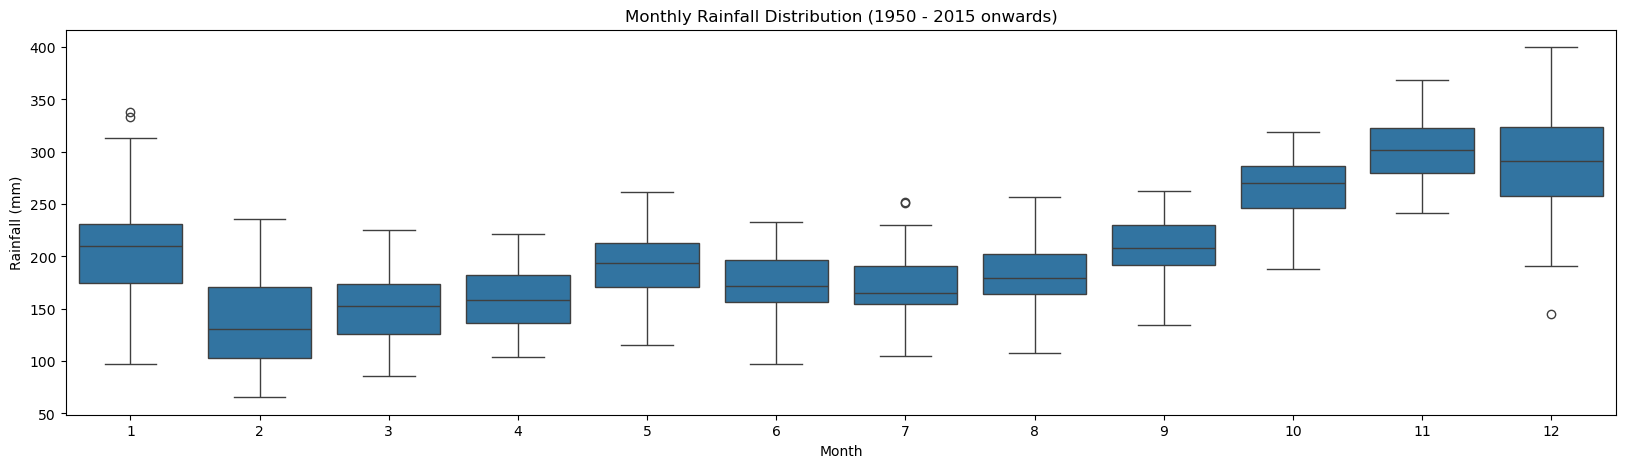

In [110]:
# caluclate the average monthly rainfall of year group

# bins for 20 years group
# bins = [1980, 2000, 2020]
# labels = ['1980-2000', '2000-2020', '2020-2040', '2040-2060', '2060-2080', '2080-2100']



# historical_climate['Year_group'] = pd.cut(historical_climate['Year'], bins=bins, labels=labels, right=False)
rainfall = historical_climate.groupby('Month')['pr'].agg(
    min = 'min',
    max = 'max',
    mean = 'mean',
).reset_index()


# range chart
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Box plot of rainfall each month
plt.figure(figsize=(20, 5))
sns.boxplot(x='Month', y='pr', data=historical_climate)
plt.title('Monthly Rainfall Distribution (1950 - 2015 onwards)')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.show()


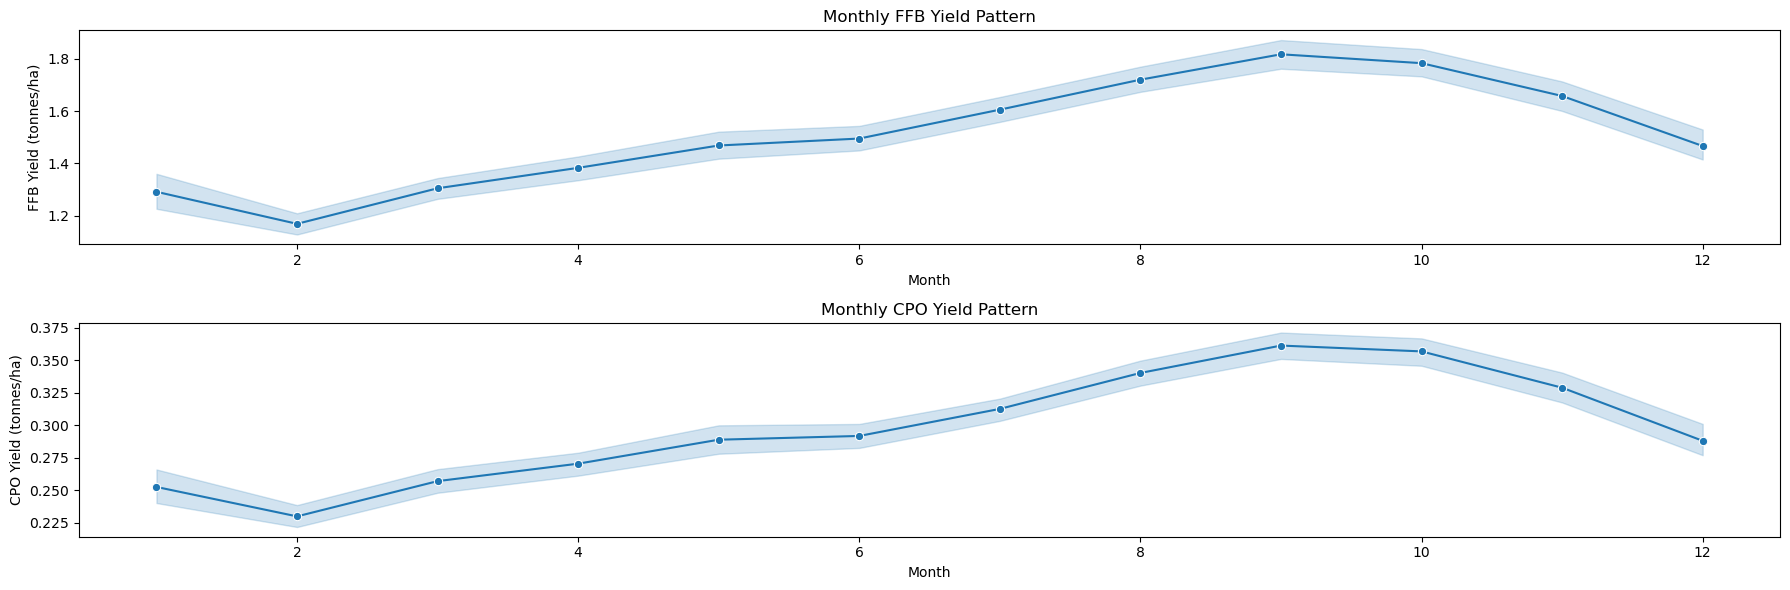

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 6))

# Monthly FFB Yield Pattern
sns.lineplot(ax=axes[0], x='Month', y='FFB_Yield', data=palm_oil, marker='o')
axes[0].set_title('Monthly FFB Yield Pattern')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('FFB Yield (tonnes/ha)')

# Monthly CPO Yield Pattern
sns.lineplot(ax=axes[1], x='Month', y='CPO_Yield', data=palm_oil, marker='o')
axes[1].set_title('Monthly CPO Yield Pattern')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('CPO Yield (tonnes/ha)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Data Preparation

In [5]:
# subset historical climate data for the year 1984 onwards
# historical_climate = pd.read_csv('historical_climate_v2.csv')
historical_climate2 = historical_climate[historical_climate['Year'] >= 1981]
# merge the historical climate data and palm oil data considering the 3 years lag
palm_oil['Year_Lag'] = palm_oil['Year'] - 3
data_lag = pd.merge(historical_climate2, palm_oil, left_on=['Year', 'Month'], right_on=['Year_Lag', 'Month'], how='left')
data_lag = data_lag.rename(columns={'Year_x': 'Year_Climate', 'Year_y' :  'Year_Harvested'}).drop(columns='Year_Lag')
# data_lag['rolling_pr_3y'] = data_lag['pr'].rolling(36, 1).sum()
# data_lag['tas_range'] = data_lag['tasmax'] - data_lag['tasmin']
# data_lag['area_harvested'] = data_lag['FFB_production'] / data_lag['FFB_Yield']
# data_lag['area_harvested_rate'] = data_lag['area_harvested'].pct_change() * 100
# data_lag = data_lag[['Year_Climate', 'Year_Harvested', 'Month', 'pr', 'rolling_pr_3y', 'tas', 'tasmin', 'tasmax', 'tas_range', 'hurs', 'cdd', 'cwd', 'sd', 'FFB_Yield', 'FFB_production', 'CPO_Yield']]
data_lag = data_lag[['Year_Climate', 'Year_Harvested', 'Month', 'pr', 'rolling_pr_3y', 'tas', 'tasmin', 'tasmax', 'tas_range', 'hurs', 'FFB_Yield', 'FFB_production', 'CPO_Yield']]
data_lag = data_lag.dropna()
data_lag.head()

,Year_Climate,Year_Harvested,Month,pr,rolling_pr_3y,tas,tasmin,tasmax,tas_range,hurs,FFB_Yield,FFB_production,CPO_Yield
36,1984,1987.0,1,202.38582,6833.530625,25.765175,24.108730,27.421620,3.312890,82.36981,1.09,1386360.0,0.21
37,1984,1987.0,2,111.37991,6868.727195,26.152502,24.379549,27.925453,3.545904,81.29495,1.04,1360834.0,0.21
38,1984,1987.0,3,138.61067,6874.331865,26.722673,24.853827,28.591520,3.737693,82.04411,1.08,1430449.0,0.22
39,1984,1987.0,4,194.13780,6953.873575,27.243454,25.327250,29.159660,3.832410,82.63734,1.20,1574587.0,0.24
40,1984,1987.0,5,214.05167,6964.645125,27.217709,25.292355,29.143057,3.850702,82.34583,1.20,1628407.0,0.23


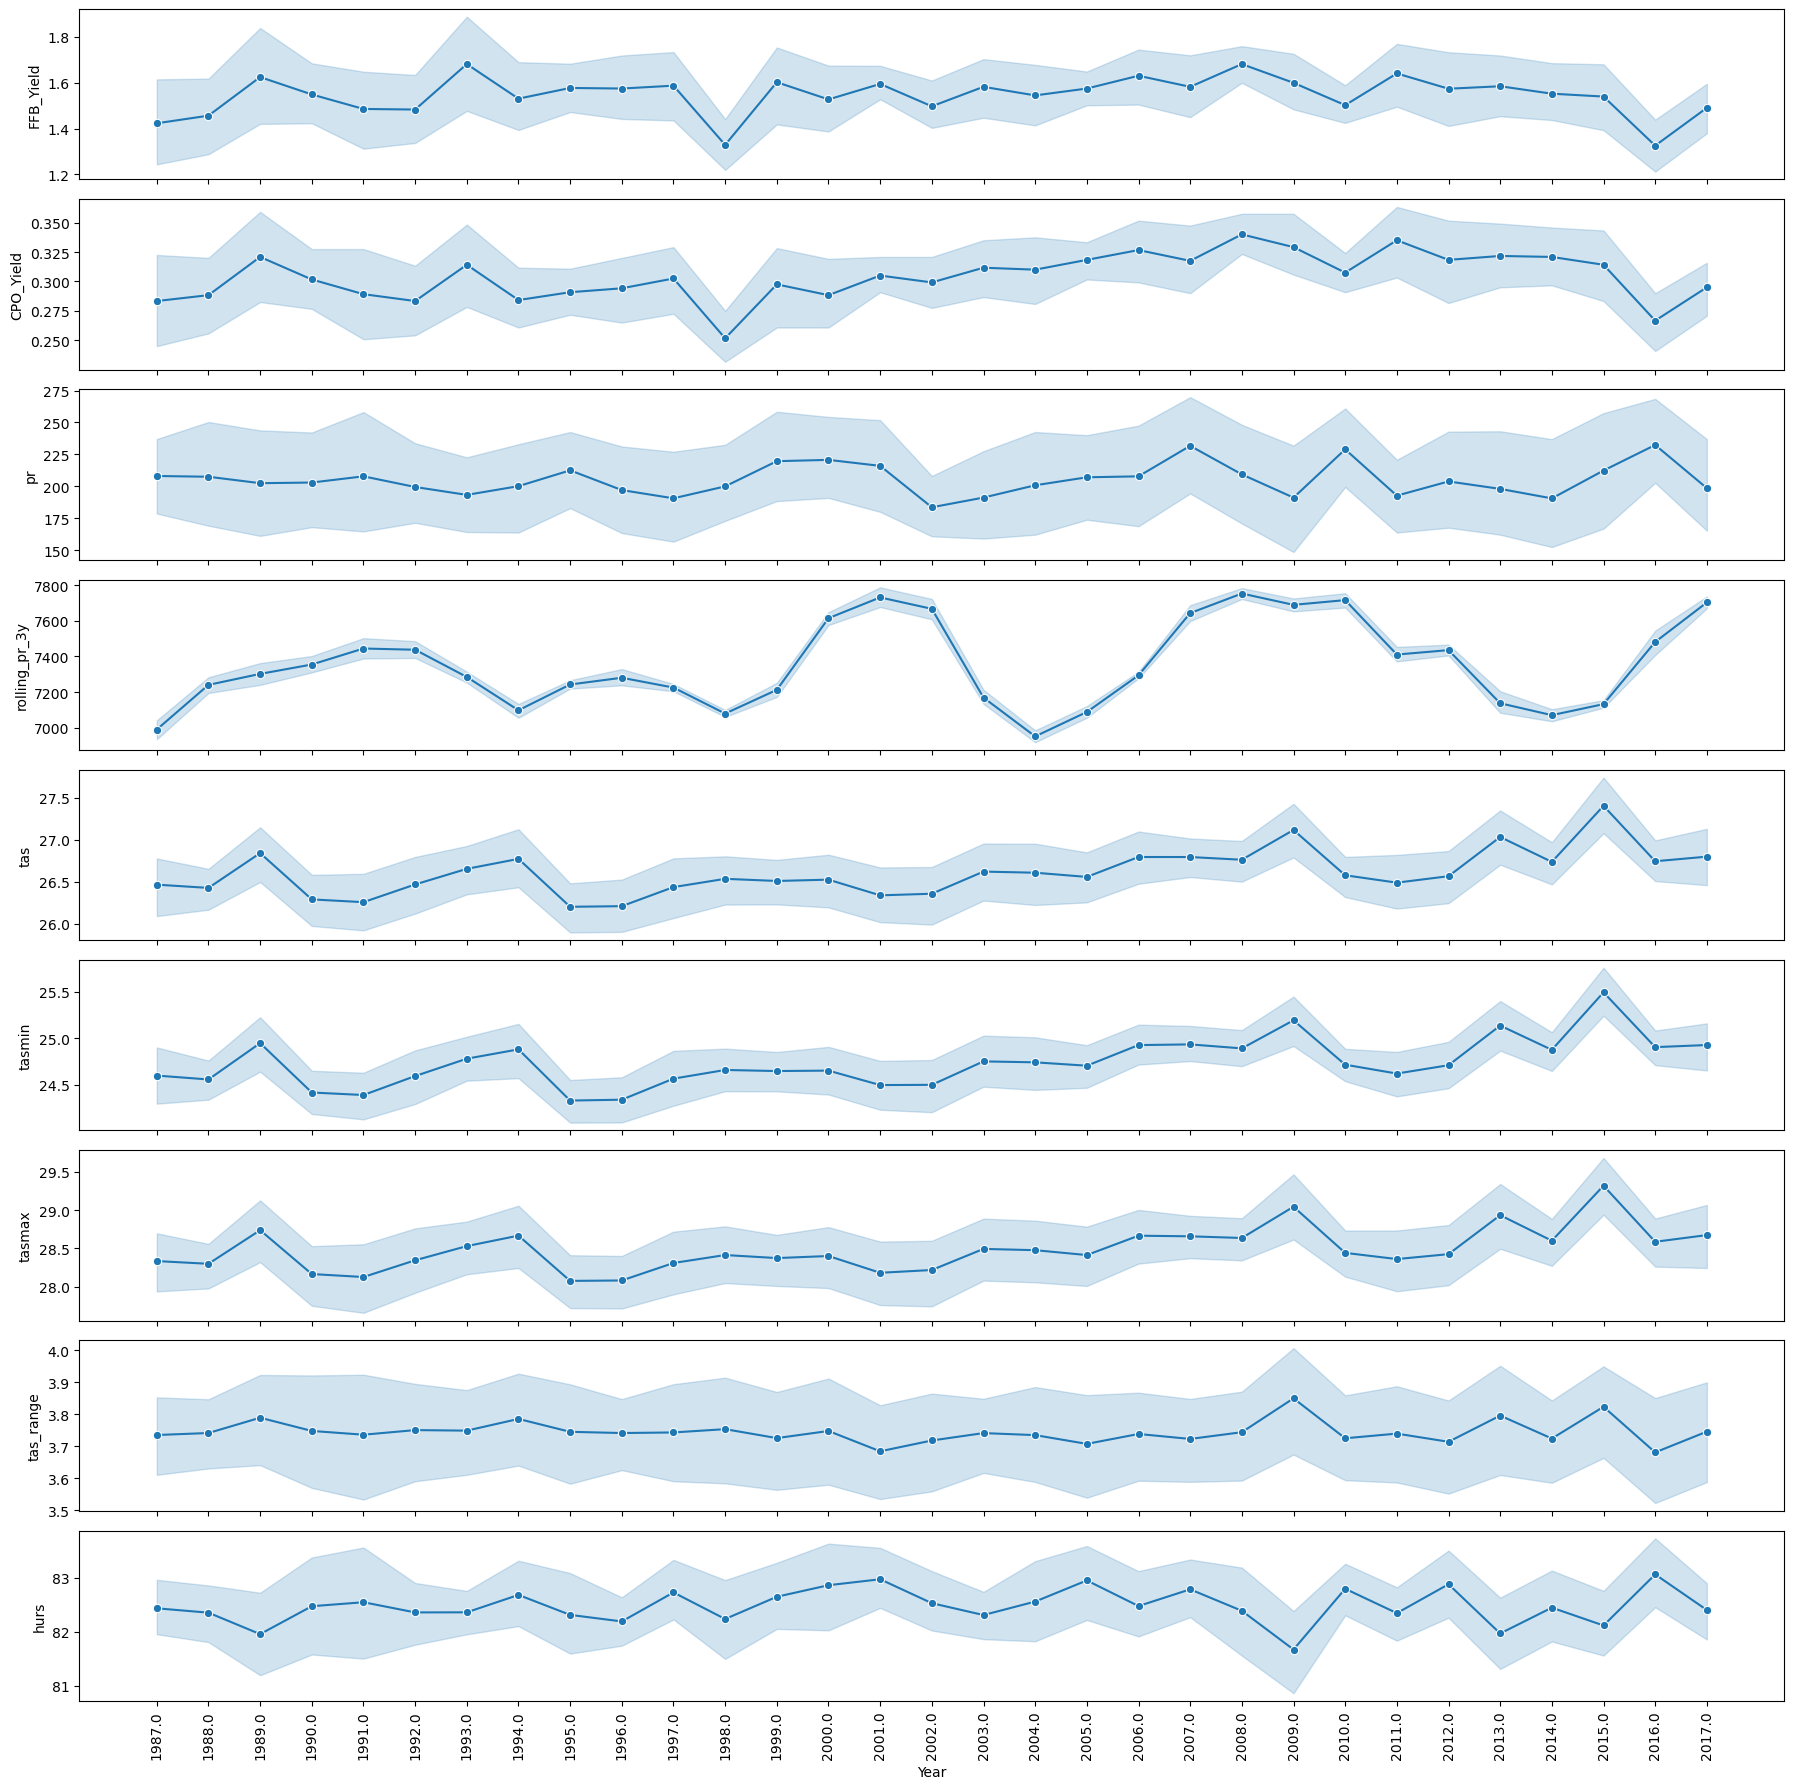

In [114]:
def visualise_trends(data, variables):
    fig, axes = plt.subplots(len(variables), 1, figsize=(18, 2 * len(variables)), sharex=True)
    
    for i, var in enumerate(variables):
        sns.lineplot(ax=axes[i], x='Year_Harvested', y=var, data=data, marker='o')
        axes[i].set_ylabel(var)
        axes[i].set_xlabel('Year')
        axes[i].set_xticks(data['Year_Harvested'].unique())
        axes[i].set_xticklabels(data['Year_Harvested'].unique(), rotation=90)
    
    plt.tight_layout()
    plt.show()

# variables = ['FFB_Yield', 'CPO_Yield', 'pr', 'rolling_pr_3y', 'tas', 'tasmin', 'tasmax', 'tas_range', 'hurs', 'cdd', 'cwd', 'sd']
variables = ['FFB_Yield', 'CPO_Yield', 'pr', 'rolling_pr_3y', 'tas', 'tasmin', 'tasmax', 'tas_range', 'hurs']
visualise_trends(data_lag, variables)


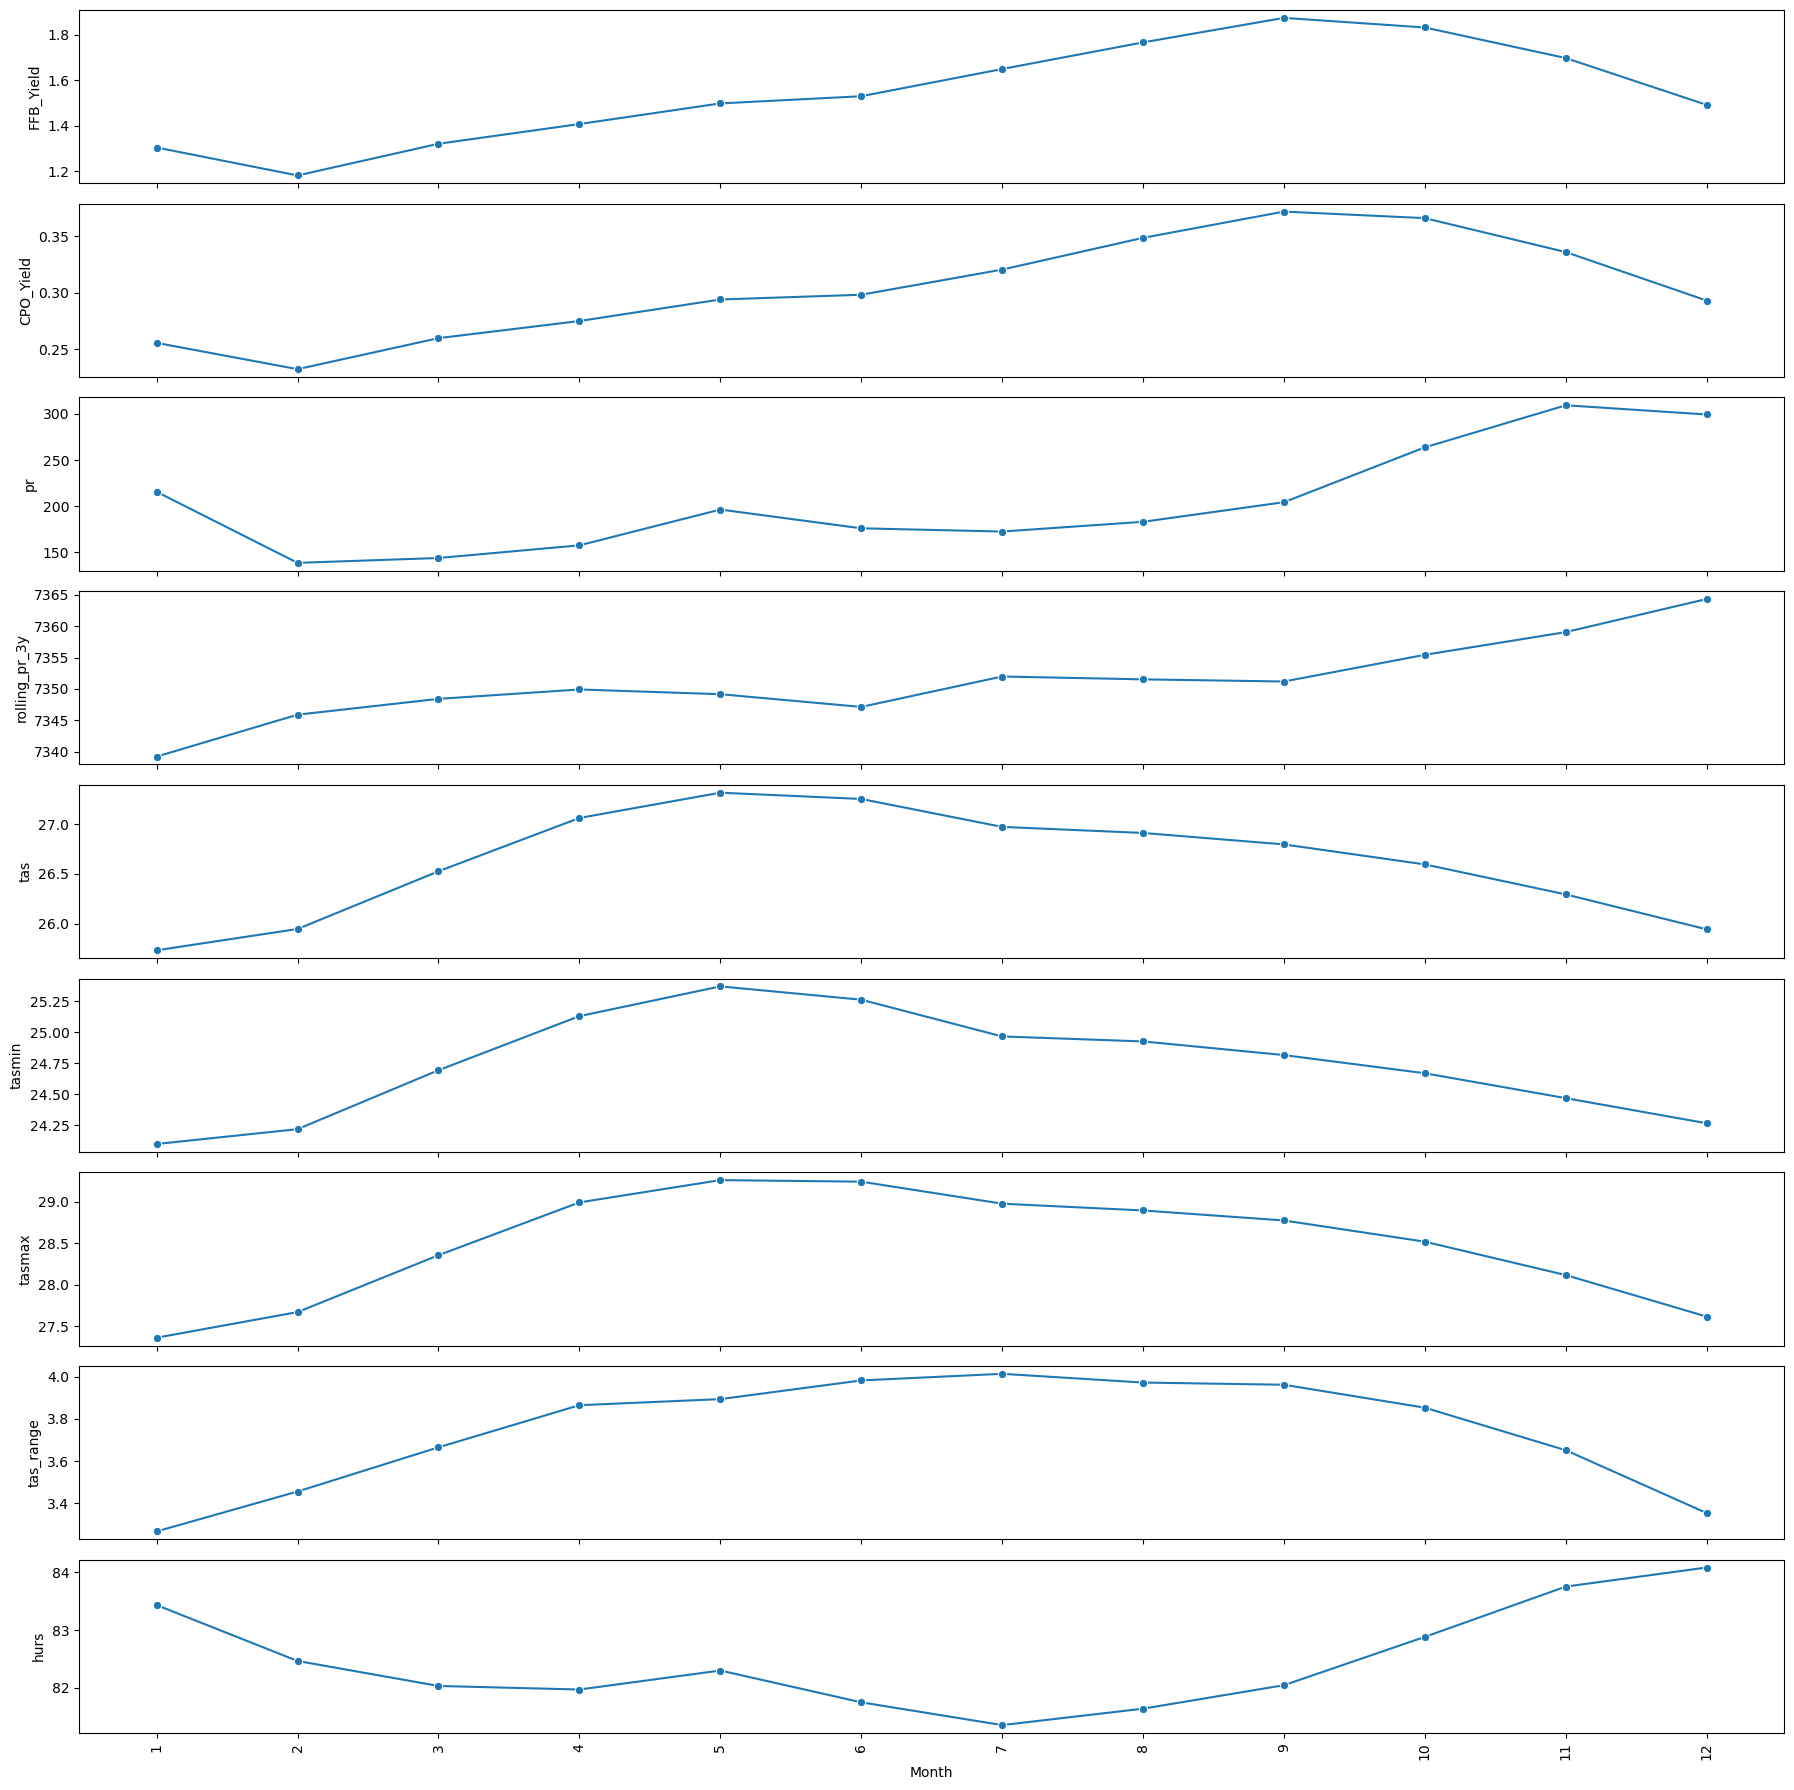

In [115]:
def visualise_trends(data, variables):
    # Group by month and calculate the mean for each variable
    monthly_avg = data.groupby('Month')[variables].mean().reset_index()
    
    fig, axes = plt.subplots(len(variables), 1, figsize=(18, 2 * len(variables)), sharex=True)
    
    for i, var in enumerate(variables):
        sns.lineplot(ax=axes[i], x='Month', y=var, data=monthly_avg, marker='o')
        axes[i].set_ylabel(var)
        axes[i].set_xlabel('Month')
        axes[i].set_xticks(monthly_avg['Month'])
        axes[i].set_xticklabels(monthly_avg['Month'], rotation=90)
    
    plt.tight_layout()
    plt.show()

variables = ['FFB_Yield', 'CPO_Yield', 'pr', 'rolling_pr_3y', 'tas', 'tasmin', 'tasmax', 'tas_range', 'hurs', 'cdd', 'cwd', 'sd']
variables = ['FFB_Yield', 'CPO_Yield', 'pr', 'rolling_pr_3y', 'tas', 'tasmin', 'tasmax', 'tas_range', 'hurs']
visualise_trends(data_lag, variables)


In [154]:
data_lag.to_csv('data_lag.csv', index=False)

In [116]:
print(f'Data Shape: {data_lag.shape}\n')
print(f'Data Skewness:\n{data_lag.skew()}\n')

Data Shape: (372, 13)

Data Skewness:
Year_Climate      0.000000
Year_Harvested    0.000000
Month             0.000000
pr                0.549182
rolling_pr_3y     0.255871
tas              -0.248837
tasmin           -0.098206
tasmax           -0.350905
tas_range        -0.593760
hurs              0.147726
FFB_Yield        -0.049182
FFB_production    0.176489
CPO_Yield        -0.037173
dtype: float64



In [117]:
print('Data Information:')
data_lag.info()

Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 372 entries, 36 to 407
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year_Climate    372 non-null    int64  
 1   Year_Harvested  372 non-null    float64
 2   Month           372 non-null    int64  
 3   pr              372 non-null    float64
 4   rolling_pr_3y   372 non-null    float64
 5   tas             372 non-null    float64
 6   tasmin          372 non-null    float64
 7   tasmax          372 non-null    float64
 8   tas_range       372 non-null    float64
 9   hurs            372 non-null    float64
 10  FFB_Yield       372 non-null    float64
 11  FFB_production  372 non-null    float64
 12  CPO_Yield       372 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 40.7 KB


#### yearly prediction?

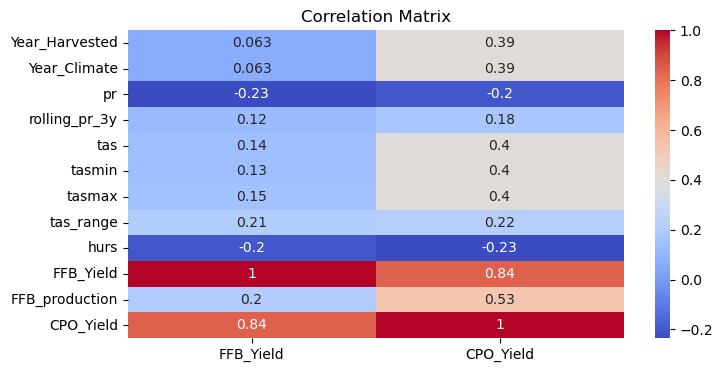

In [125]:
data_test = data_lag.groupby('Year_Harvested').mean().reset_index()
data_test.drop(columns='Month', inplace=True)
correlation = data_test.corr()
correlation = correlation[['FFB_Yield', 'CPO_Yield']]

plt.figure(figsize=(8, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# visualize the correlation matrix


In [126]:
# simple model to predict FFB Yield
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# split the data
X = data_lag[['pr', 'rolling_pr_3y', 'tas', 'tasmin', 'tasmax', 'tas_range', 'hurs']]
y = data_lag['FFB_Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model
model = LinearRegression()
model.fit(X_train, y_train)

# predict the FFB Yield
y_pred = model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


Mean Squared Error: 0.027236064364486202
R2 Score: 0.601537479875067


In [128]:
# feature importance
importance = model.coef_
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
4,tasmax,551.323144
3,tasmin,550.744041
5,tas_range,0.579103
6,hurs,0.010471
0,pr,0.001990
1,rolling_pr_3y,0.000018
2,tas,-1102.190130


#### correlation 

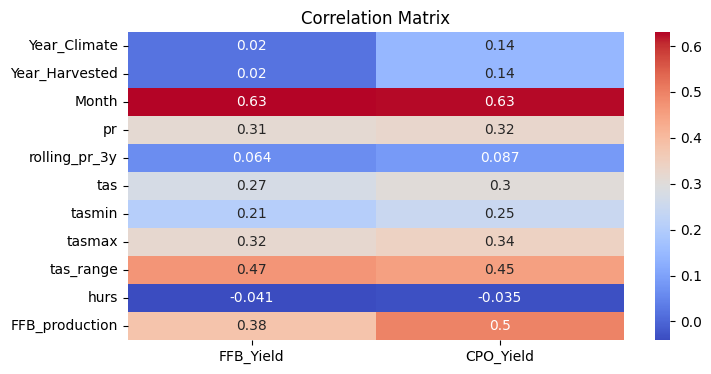

In [7]:
# heatplot correlation matrix of features with target variable [area harvested, production, yield]
import seaborn as sns
import matplotlib.pyplot as plt

target = ['FFB_Yield','CPO_Yield']
climate_features = data_lag.drop(target, axis=1).columns
time_features = ['Year_Climate', 'Year_Harvested', 'Month']

correlation = data_lag.corr()
correlation = correlation[target] 
correlation = correlation.drop(target, axis=0)

plt.figure(figsize=(8, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


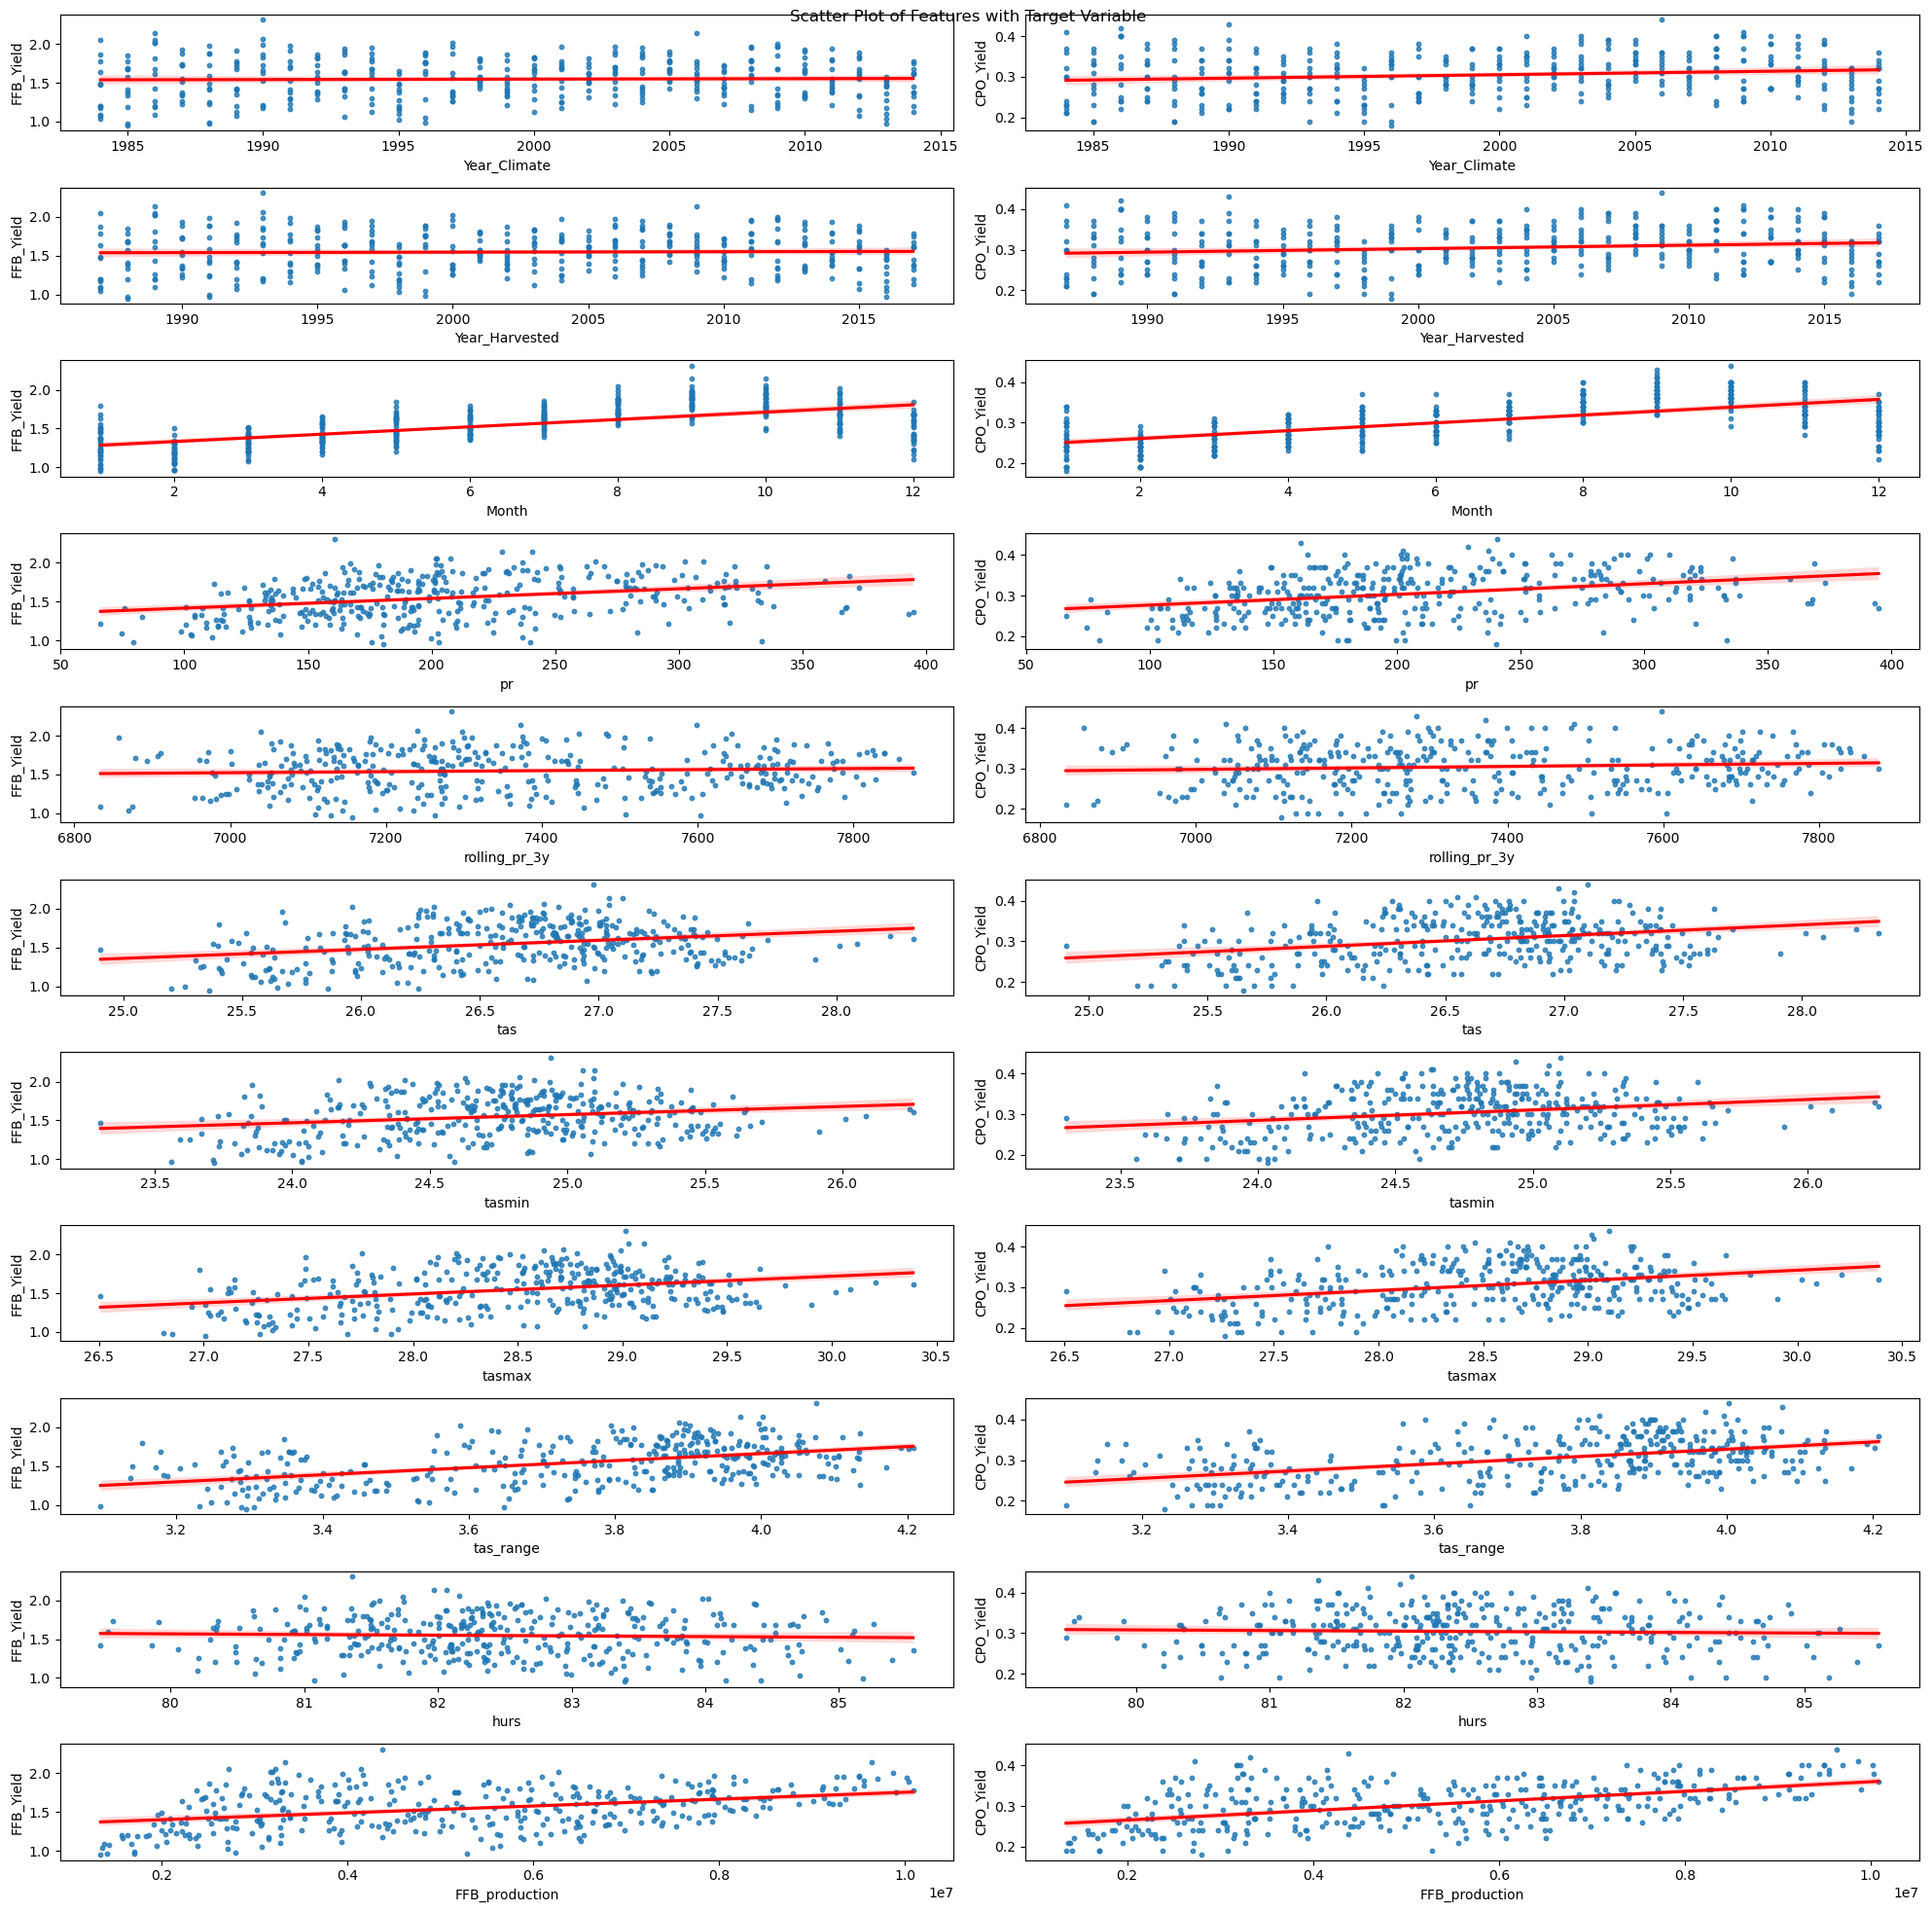

In [129]:
import seaborn as sns

# plot scatter plot of climate features with target variable [FFB yield, FFB production, CPO yield]
fig, axes = plt.subplots(len(climate_features), len(target), figsize=(20, 20))
fig.suptitle('Scatter Plot of Features with Target Variable')

for i, target_var in enumerate(climate_features):
    for j, feature in enumerate(target):
        sns.regplot(ax=axes[i, j], x=data_lag[target_var], y=data_lag[feature], scatter_kws={'s': 10}, line_kws={'color': 'red'})
        axes[i, j].set_ylabel(feature)
        axes[i, j].set_xlabel(target_var)
        
plt.tight_layout()
plt.show()

In [130]:
# print coorelation matrix
correlation = data_lag.corr()
correlation = correlation[target]
correlation = correlation.drop(target, axis=0)
correlation

,FFB_Yield,CPO_Yield
Year_Climate,0.020009,0.144329
Year_Harvested,0.020009,0.144329
Month,0.629849,0.625750
pr,0.313831,0.323670
rolling_pr_3y,0.063888,0.086938
tas,0.274292,0.303046
tasmin,0.206315,0.245481
tasmax,0.318176,0.339191
tas_range,0.468101,0.450407
hurs,-0.040716,-0.034716


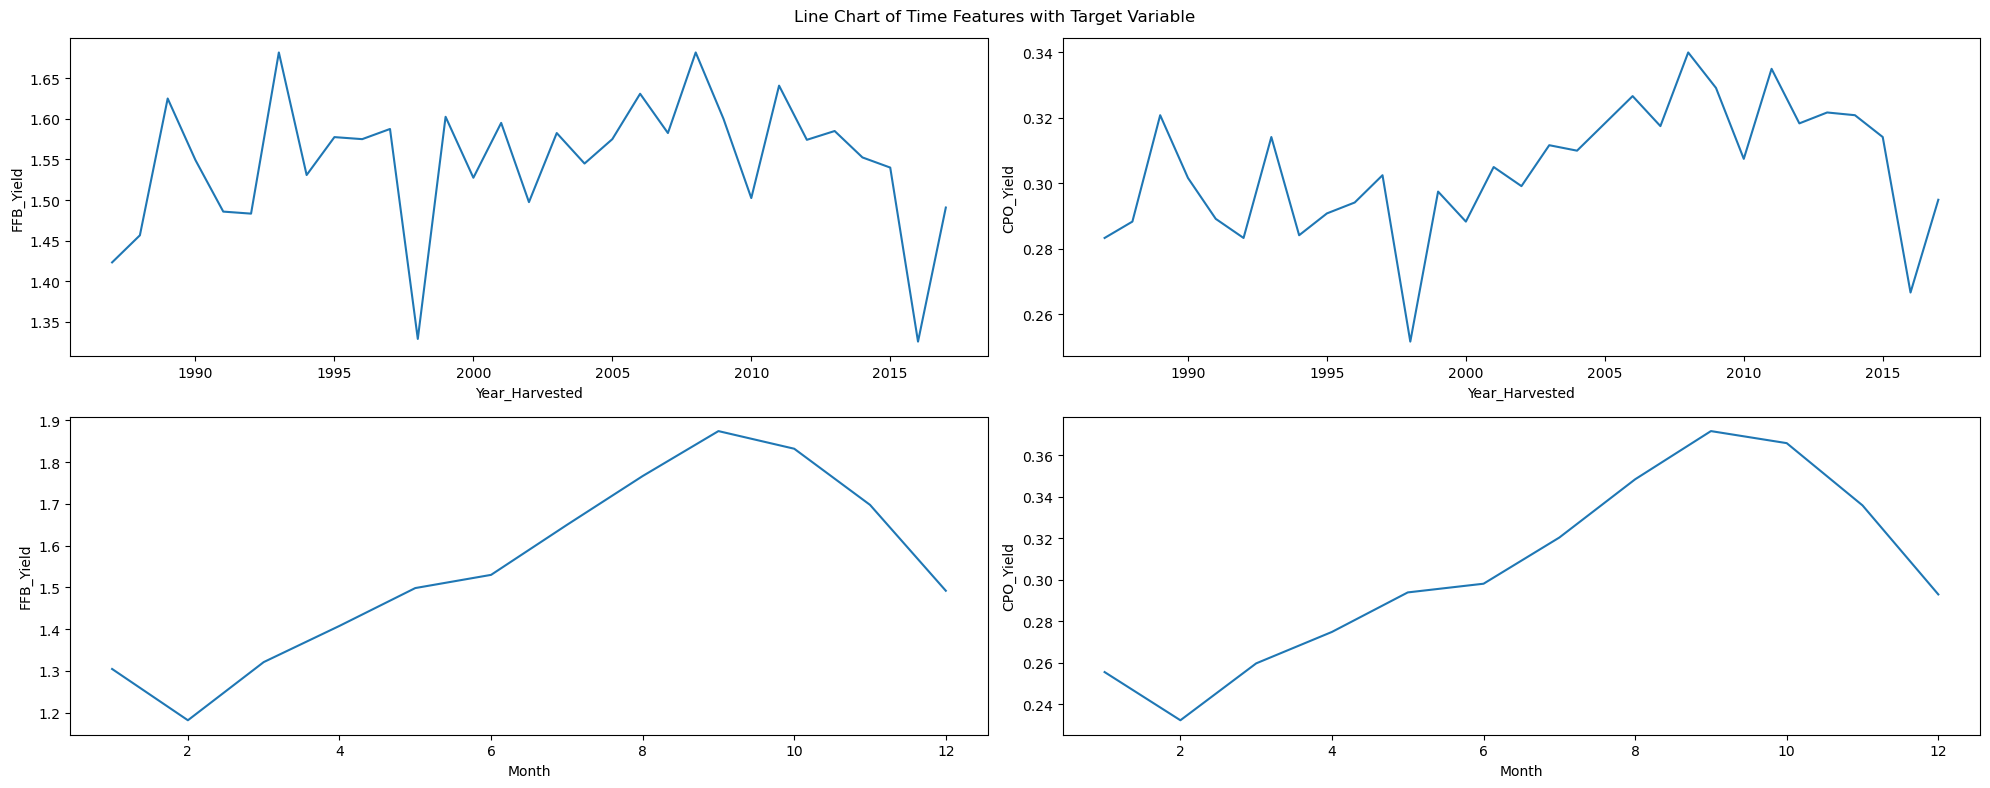

In [133]:
# plot line chart of time features with average of target variable [FFB yield, FFB production, CPO yield]
fig, axes = plt.subplots(len(time_features), len(target), figsize=(20, 8))
fig.suptitle('Line Chart of Time Features with Target Variable')

for i, target_var in enumerate(time_features):
    for j, feature in enumerate(target):
        data_lag.groupby(target_var)[feature].mean().plot(ax=axes[i, j])
        axes[i, j].set_ylabel(feature)
        axes[i, j].set_xlabel(target_var)
plt.tight_layout()        
plt.show()

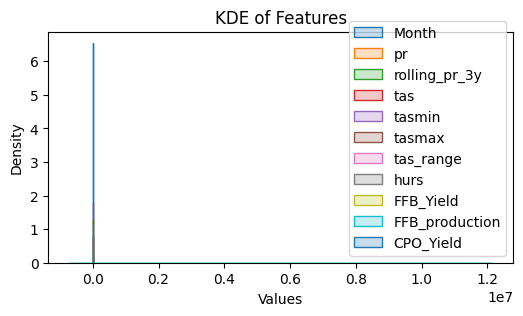

In [8]:
# kde of all features in one graph
import seaborn as sns
import matplotlib.pyplot as plt

data = data_lag.drop(['Year_Climate', 'Year_Harvested'], axis=1)
# Plot KDE of all features
plt.figure(figsize=(6,3))
for feature in data.columns:
    sns.kdeplot(data[feature], label=feature, fill=True)
plt.title('KDE of Features')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

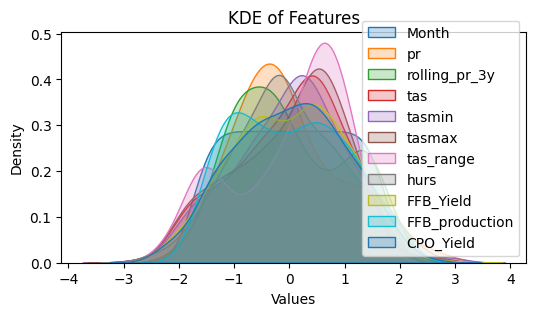

In [9]:
# kde of all features in one graph
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

ss_scaler = StandardScaler()

data = data_lag.drop(['Year_Climate', 'Year_Harvested'], axis=1)
data = pd.DataFrame(ss_scaler.fit_transform(data), columns=data.columns)

# Plot KDE of all features
plt.figure(figsize=(6,3))
for feature in data.columns:
    sns.kdeplot(data[feature], label=feature, fill=True)
plt.title('KDE of Features')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

### data profile

In [101]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(data_lag, title='Palm Oil Data Profiling Report', explorative=True)
# profile.to_notebook_iframe()

# Modeling [FFB yield]

In [87]:
# import libraries
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# method to train and append model results to the results table
def train_and_append_results(X, y, target, model, normalization, resultstable):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Append the results to the table
    resultstable.loc[len(resultstable)] = [target, model.__class__.__name__, normalization, mse, rmse, mae, r2]


In [88]:
# Split the data into features and target variable
X = data_lag.drop(columns=['FFB_Yield', 'FFB_production', 'CPO_Yield', 'Year_Climate', 'Year_Harvested'])
y = data_lag['FFB_Yield']

# Normalize the features and target variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
X_sscaled = scaler.fit_transform(X)

# create table to store the results
results_ffb = pd.DataFrame(columns=['Target', 'Model', 'Normalization', 'MSE', 'RMSE', 'MAE', 'R2'])

In [89]:
# Define the models
model_LR = LinearRegression() # linear regression model 
model_DTR = DecisionTreeRegressor() # Decision Tree Regressor model
model_RFR = RandomForestRegressor()  # Random Forest Regressor model
model_SVR = SVR() # Support Vector Regressor model

train_and_append_results(X_sscaled, y, 'FFB_Yield', model_LR, 'SS', results_ffb) 
train_and_append_results(X_sscaled, y, 'FFB_Yield', model_DTR, 'SS', results_ffb)
train_and_append_results(X_sscaled, y, 'FFB_Yield', model_RFR, 'SS', results_ffb)
train_and_append_results(X_sscaled, y, 'FFB_Yield', model_SVR, 'SS', results_ffb) 

results_ffb.sort_values('R2', ascending=False)

,Target,Model,Normalization,MSE,RMSE,MAE,R2
2,FFB_Yield,RandomForestRegressor,SS,0.021223,0.145680,0.124460,0.689513
3,FFB_Yield,SVR,SS,0.022079,0.148591,0.125291,0.676983
0,FFB_Yield,LinearRegression,SS,0.025023,0.158186,0.134637,0.633918
1,FFB_Yield,DecisionTreeRegressor,SS,0.038527,0.196282,0.152667,0.436356


### Model Evaluation

- RMSE: Lower values better
- R2: 0.5 - 0.7
- MAE: lower values better

In [90]:
best_scalling = results_ffb.groupby('Normalization')['R2'].mean()
best_model = results_ffb.groupby('Model')['R2'].mean()

print(f'Best Scalling Method: {best_scalling.idxmax()}')
print(f'Best Model: {best_model.idxmax()}')

Best Scalling Method: SS
Best Model: RandomForestRegressor


In [93]:
# X = data_lag.drop(columns=['FFB_Yield', 'FFB_production', 'CPO_Yield','Month', 'Year_Climate', 'Year_Harvested', 'hurs', 'tas', 'tasmin', 'tasmax'])

MSE: 0.021376777866666644
RMSE: 0.14620799522141956
MAE: 0.1251546666666666
R2: 0.6872586043668807


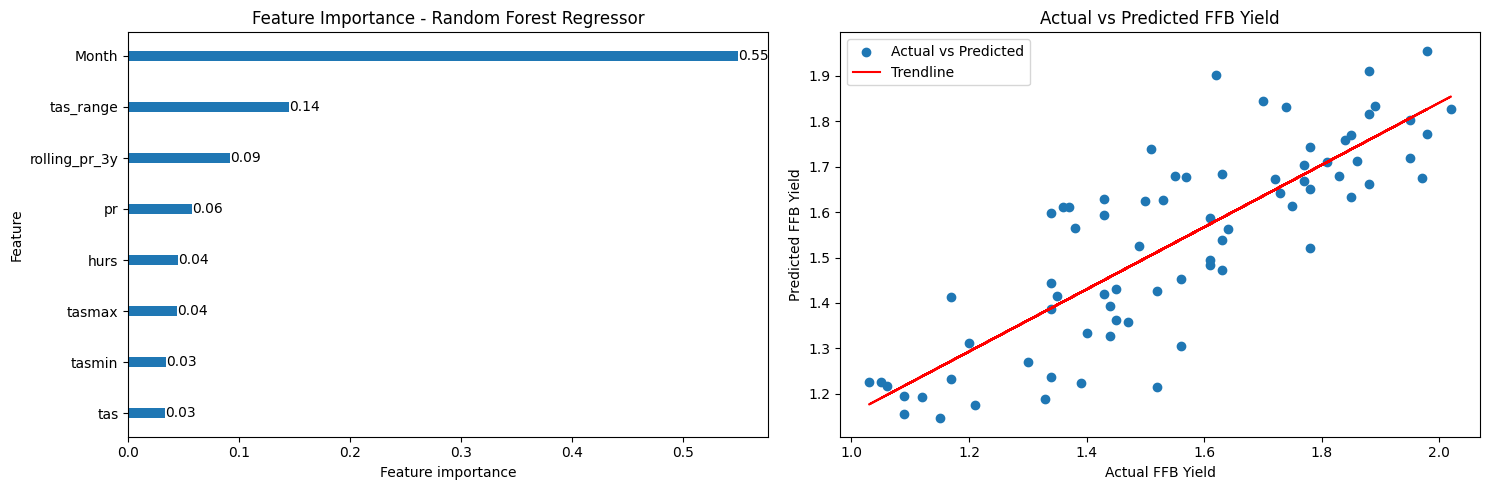

In [91]:
# recreate model with the best normalization and model
import numpy as np
X = data_lag.drop(columns=['FFB_Yield', 'FFB_production', 'CPO_Yield', 'Year_Climate', 'Year_Harvested'])
X_sscaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_sscaled, y, test_size=0.2, random_state=42)

model_RFR.fit(X_train, y_train)
y_pred = model_RFR.predict(X_test)
print (f'MSE: {mean_squared_error(y_test, y_pred)}')
print (f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
print (f'MAE: {mean_absolute_error(y_test, y_pred)}')
print (f'R2: {r2_score(y_test, y_pred)}')


# print feature importance
importances = model_RFR.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
# Plot feature importance in the first subplot
ax[0].barh(range(X.shape[1]), importances[indices], align="center", height=0.2)
ax[0].set_yticks(range(X.shape[1]))
ax[0].set_yticklabels([features[i] for i in indices])
ax[0].set_xlabel("Feature importance")
ax[0].set_ylabel("Feature")
ax[0].set_title("Feature Importance - Random Forest Regressor")
ax[0].invert_yaxis()  # Reverse the order of features

# Add data labels to the feature importance plot
for i in range(X.shape[1]):
    ax[0].text(importances[indices][i], i, f"{importances[indices][i]:.2f}", va='center')

# Plot actual vs predicted values in the second subplot
ax[1].scatter(y_test, y_pred, label='Actual vs Predicted')
ax[1].set_xlabel('Actual FFB Yield')
ax[1].set_ylabel('Predicted FFB Yield')
ax[1].set_title('Actual vs Predicted FFB Yield')

# Add a trend line to the actual vs predicted plot
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax[1].plot(y_test, p(y_test), color='red', label='Trendline')

ax[1].legend()

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()



## Hypertuning 

In [21]:
# get model parameters
for p in model_RFR.get_params():
    print(f'{p}: {model_RFR.get_params()[p]}')
    
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['sqrt', 'log2', None]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False] 

random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}


bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [48]:
model_RFR_random = RandomizedSearchCV(estimator = model_RFR, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
model_RFR_random.fit(X_train, y_train)

for p in model_RFR_random.best_params_:
    print(f'{p}: {model_RFR_random.best_params_[p]}')
    


Fitting 5 folds for each of 100 candidates, totalling 500 fits
n_estimators: 600
min_samples_split: 10
min_samples_leaf: 4
max_features: log2
max_depth: 40
bootstrap: True


In [100]:
# compare original model with the best model
def evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Model: {name} Performance')
    print(f'R2: {r2_score(y_test, y_pred)}')
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print('-----------------------------------\n')
    
    return [name, r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), root_mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)]


# comparison of the two models
results = pd.DataFrame(columns=['Model', 'R2', 'MSE', 'RMSE', 'MAE'])
results.loc[len(results)] = evaluate(model_RFR, 'base')
results.loc[len(results)] = evaluate(model_RFR_random.best_estimator_, 'best param')

print(f'Improvement: {((results.iloc[1, 1] - results.iloc[0, 1])/results.iloc[0,1] * 100):0.2f}%')   

Model: base Performance
R2: 0.701970977411343
MSE: 0.020371144666666632
RMSE: 0.1427275189536574
MAE: 0.1231053333333333
-----------------------------------

Model: best param Performance
R2: 0.6718632525316248
MSE: 0.022429094640067242
RMSE: 0.14976346229994564
MAE: 0.13037680164287094
-----------------------------------

Improvement: -4.29%


In [112]:
X = data_lag.drop(columns=['FFB_Yield', 'FFB_production', 'CPO_Yield','Year_Climate', 'Year_Harvested'])
X.columns

Index(['Month', 'pr', 'rolling_pr_3y', 'tas', 'tasmin', 'tasmax', 'tas_range',
       'hurs'],
      dtype='object')

In [113]:
# save the model
import joblib
from sklearn.pipeline import Pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_RFR_random.best_estimator_)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

# joblib.dump(pipeline, 'ffb_yield_model2.pkl')
joblib.dump(pipeline, 'streamlit/ffb_yield_model2.pkl')


R2: 0.6732807205581114
MSE: 0.02233220660554925
RMSE: 0.14943964201492604
MAE: 0.130042893961774


['streamlit/ffb_yield_model2.pkl']

In [126]:
# test the model
import joblib

model = joblib.load('streamlit/ffb_yield_model2.pkl')
testdata = pd.read_csv('streamlit/data/ssp126_climate3.csv')

testdata.columns
X = testdata[['Month', 'pr', 'rolling_pr_3y', 'tas', 'tasmin', 'tasmax', 'tas_range', 'hurs']]

y_pred = model.predict(X)

# Modelling [CPO Yield]

In [128]:
# Split the data into features and target variable
X = data_lag.drop(columns=['FFB_Yield', 'FFB_production', 'CPO_Yield', 'Year_Climate', 'Year_Harvested'])
y = data_lag['CPO_Yield']

# Normalize the features and target variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_sscaled = scaler.fit_transform(X)

# create table to store the results
results_cpo = pd.DataFrame(columns=['Target', 'Model', 'Normalization', 'MSE', 'RMSE', 'MAE', 'R2'])

In [129]:
# Define the models
model_LR = LinearRegression() # linear regression model
model_DTR = DecisionTreeRegressor() # Decision Tree Regressor model
model_RFR = RandomForestRegressor()  # Random Forest Regressor model
model_SVR = SVR() # Support Vector Regressor model

train_and_append_results(X_sscaled, y, 'CPO_Yield', model_LR, 'SS', results_cpo)
train_and_append_results(X_sscaled, y, 'CPO_Yield', model_DTR, 'SS', results_cpo)
train_and_append_results(X_sscaled, y, 'CPO_Yield', model_RFR, 'SS', results_cpo)
train_and_append_results(X_sscaled, y, 'CPO_Yield', model_SVR, 'SS', results_cpo)

results_cpo.sort_values('R2', ascending=False)


,Target,Model,Normalization,MSE,RMSE,MAE,R2
2,CPO_Yield,RandomForestRegressor,SS,0.001124,0.033519,0.028356,0.612278
0,CPO_Yield,LinearRegression,SS,0.001149,0.033901,0.028118,0.603394
3,CPO_Yield,SVR,SS,0.002228,0.047199,0.038208,0.231207
1,CPO_Yield,DecisionTreeRegressor,SS,0.002600,0.050990,0.043467,0.102739


### Model Evaluation

In [130]:
X = data_lag.drop(columns=['FFB_Yield', 'FFB_production', 'CPO_Yield', 'Year_Climate', 'Year_Harvested'])
X.columns

Index(['Month', 'pr', 'rolling_pr_3y', 'tas', 'tasmin', 'tasmax', 'tas_range',
       'hurs'],
      dtype='object')

MSE: 0.0011279892000000005
RMSE: 0.033585550464448256
MAE: 0.02842799999999998
R2: 0.610730370683943


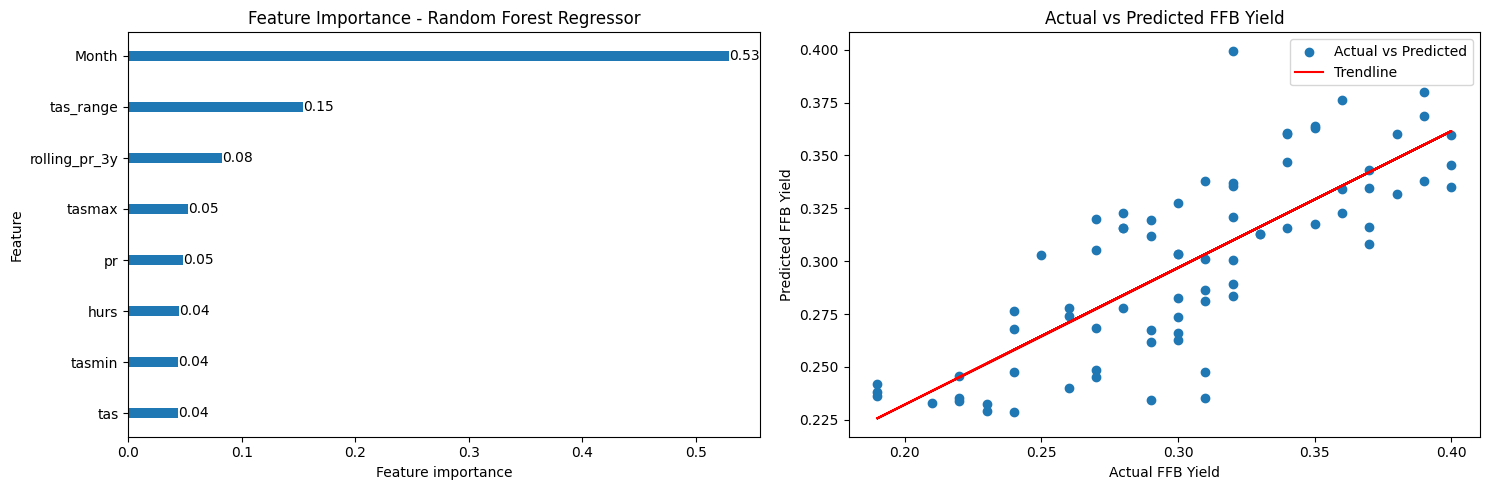

In [131]:
scaler = StandardScaler()
X_sscaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_sscaled, y, test_size=0.2, random_state=42)

# recreate best model
model_RFR.fit(X_train, y_train)
y_pred = model_RFR.predict(X_test)
print (f'MSE: {mean_squared_error(y_test, y_pred)}')
print (f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
print (f'MAE: {mean_absolute_error(y_test, y_pred)}')
print (f'R2: {r2_score(y_test, y_pred)}')


# print feature importance
importances = model_RFR.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
# Plot feature importance in the first subplot
ax[0].barh(range(X.shape[1]), importances[indices], align="center", height=0.2)
ax[0].set_yticks(range(X.shape[1]))
ax[0].set_yticklabels([features[i] for i in indices])
ax[0].set_xlabel("Feature importance")
ax[0].set_ylabel("Feature")
ax[0].set_title("Feature Importance - Random Forest Regressor")
ax[0].invert_yaxis()  # Reverse the order of features

# Add data labels to the feature importance plot
for i in range(X.shape[1]):
    ax[0].text(importances[indices][i], i, f"{importances[indices][i]:.2f}", va='center')

# Plot actual vs predicted values in the second subplot
ax[1].scatter(y_test, y_pred, label='Actual vs Predicted')
ax[1].set_xlabel('Actual FFB Yield')
ax[1].set_ylabel('Predicted FFB Yield')
ax[1].set_title('Actual vs Predicted FFB Yield')

# Add a trend line to the actual vs predicted plot
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax[1].plot(y_test, p(y_test), color='red', label='Trendline')

ax[1].legend()

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()

In [168]:
# # feature selection with stepwise selection
# from sklearn.model_selection import cross_val_score
# import itertools

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# def forward_selection(X, y, model, cv=5):
#     initial_features = X.columns
#     best_score = -float('inf')
#     best_features = []

#     # Iterate over all subsets of features
#     for k in range(1, len(initial_features) + 1):
#         for feature_subset in itertools.combinations(initial_features, k):
#             X_subset = X[list(feature_subset)]
#             score = cross_val_score(model, X_subset, y, cv=cv, scoring='neg_mean_squared_error').mean()
#             if score > best_score:
#                 best_score = score
#                 best_features = feature_subset

#     return best_features

# selected_features = forward_selection(X_train, y_train, model_RFR)
# print(selected_features)

### Hypertuning

In [132]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['sqrt', 'log2', None]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False] 

random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

model_RFR_random = RandomizedSearchCV(estimator = model_RFR, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
model_RFR_random.fit(X_train, y_train)

for p in model_RFR_random.best_params_:
    print(f'{p}: {model_RFR_random.best_params_[p]}')


Fitting 3 folds for each of 100 candidates, totalling 300 fits
n_estimators: 400
min_samples_split: 10
min_samples_leaf: 2
max_features: log2
max_depth: 50
bootstrap: True


In [133]:
# compare original model with the best model
def evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Model: {name} Performance')
    print(f'R2: {r2_score(y_test, y_pred)}')
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print('-----------------------------------\n')
    
    return [name, r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), root_mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)]


# comparison of the two models
results = pd.DataFrame(columns=['Model', 'R2', 'MSE', 'RMSE', 'MAE'])
results.loc[len(results)] = evaluate(model_RFR, 'base')
results.loc[len(results)] = evaluate(model_RFR_random.best_estimator_, 'best param')

print(f'Improvement: {((results.iloc[1, 1] - results.iloc[0, 1])/results.iloc[0,1] * 100):0.2f}%')   

Model: base Performance
R2: 0.6197890745785168
MSE: 0.0011017397333333346
RMSE: 0.03319246500839211
MAE: 0.028152000000000007
-----------------------------------

Model: best param Performance
R2: 0.6371857085053121
MSE: 0.0010513293912261003
RMSE: 0.03242420995531117
MAE: 0.027694325504135555
-----------------------------------

Improvement: 2.81%


In [134]:
print(X.columns)

Index(['Month', 'pr', 'rolling_pr_3y', 'tas', 'tasmin', 'tasmax', 'tas_range',
       'hurs'],
      dtype='object')


In [135]:
print(y.name)

CPO_Yield


In [137]:
# save the model
import joblib
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_RFR_random.best_estimator_)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

joblib.dump(pipeline, 'streamlit/cpo_yield_model2.pkl')

R2: 0.6367480783210245
MSE: 0.001052597515128645
RMSE: 0.03244375926320261
MAE: 0.027777349569763223


['streamlit/cpo_yield_model2.pkl']

# Prediction

### get ssp projection data


In [103]:
# list of ssp
ssp = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
variables = ['pr', 'tas', 'hurs']

# cycle to the links and download the data
for s in ssp:
    climate_df = pd.DataFrame()
    
    for v in variables:
        url = f"data/cmip6-x0.25/{v}/access-cm2-r1i1p1f1-{s}/timeseries-{v}-monthly-mean_cmip6-x0.25_access-cm2-r1i1p1f1-{s}_timeseries_mean_2015-2100.nc"
        
        # read and aggregate data
        temp_df = read_and_aggregate_data(url, f'timeseries-{v}-monthly-mean').rename(columns={f'timeseries-{v}-monthly-mean': v})
        
        # if dataframe is empty, assign the first variable
        if climate_df.empty:
            climate_df = temp_df[['time', v]]
        else:
            climate_df[v] = temp_df[v]
            
    # split into year and month
    climate_df[['Year', 'Month']] = climate_df['time'].dt.strftime('%Y-%m').str.split('-', expand=True)
    climate_df[['Year', 'Month']] = climate_df[['Year', 'Month']].astype(int)
    climate_df = climate_df[['Year', 'Month', 'pr', 'tas', 'hurs']]
    
    # save the data to csv
    climate_df.to_csv(f'{s}_climate.csv', index=False)
    print(f'{s}_climate.csv saved')
        


### generate prediction from ssp seasonal data 

In [16]:
# get data from cckp api
import requests

# request data for humidity, precipitation, and temperature for Malaysia
url = "https://cckpapi.worldbank.org/cckp/v1/cmip6-x0.25_timeseries_hurs,pr,tas_timeseries_seasonal_2015-2100_median_ssp126,ssp245,ssp370,ssp585_ensemble_all_mean/MYS?_format=json"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    print(data)
else:
    print("Error:", response.status_code)

{'metadata': {'apiVersion': 'v1', 'status': 'success', 'messages': []}, 'data': {'hurs': {'ssp126': {'MYS': {'2015-01': None, '2015-04': 81.06, '2015-07': 80.91, '2015-10': 82.53, '2016-01': 82.11, '2016-04': 80.97, '2016-07': 81.27, '2016-10': 82.55, '2017-01': 82.37, '2017-04': 81.39, '2017-07': 81.26, '2017-10': 82.42, '2018-01': 82.03, '2018-04': 81.09, '2018-07': 81.06, '2018-10': 82.38, '2019-01': 82.04, '2019-04': 80.94, '2019-07': 81.03, '2019-10': 82.52, '2020-01': 81.77, '2020-04': 80.62, '2020-07': 81.21, '2020-10': 82.45, '2021-01': 82.05, '2021-04': 81.13, '2021-07': 81.18, '2021-10': 82.41, '2022-01': 82.22, '2022-04': 81.37, '2022-07': 81.05, '2022-10': 82.44, '2023-01': 82.16, '2023-04': 80.95, '2023-07': 81.1, '2023-10': 82.3, '2024-01': 81.72, '2024-04': 80.36, '2024-07': 81.13, '2024-10': 82.29, '2025-01': 82.58, '2025-04': 81.34, '2025-07': 81.45, '2025-10': 82.6, '2026-01': 82.18, '2026-04': 81.13, '2026-07': 81.31, '2026-10': 82.29, '2027-01': 82.33, '2027-04': 80

In [17]:
import pandas as pd

# Extract data from JSON to create a DataFrame
def create_dataframe(data, ssp):
    
    # Extract pr data
    ssp_data = data['pr'][ssp]["MYS"]
    variable_df = pd.DataFrame(ssp_data.items(), columns=["Year", 'pr'])
    variable_df['tas'] = data['tas'][ssp]["MYS"].values()
    variable_df['hurs'] = data['hurs'][ssp]["MYS"].values()
    variable_df.rename(columns={"Year": "Date"}, inplace=True)
    variable_df[['Year', 'Month']] = variable_df['Date'].str.split('-', expand=True)
    variable_df[['Year', 'Month']] = variable_df[['Year', 'Month']].astype(int)
    variable_df['Date'] = pd.to_datetime(variable_df['Date']).dt.strftime('%Y-%m')
    variable_df['Year'] = pd.to_datetime(variable_df['Year'], format='%Y').dt.year
    variable_df['Month'] = pd.to_datetime(variable_df['Month'], format='%m').dt.month
    variable_df = variable_df[['Date','Year', 'Month', 'pr', 'tas', 'hurs']]

    return variable_df

In [18]:
ssp126_df = create_dataframe(data["data"], "ssp126") # get data for ssp126
ssp245_df = create_dataframe(data["data"], "ssp245") # get data for ssp245
ssp370_df = create_dataframe(data["data"], "ssp370") # get data for ssp370
ssp585_df = create_dataframe(data["data"], "ssp585") # get data for ssp585

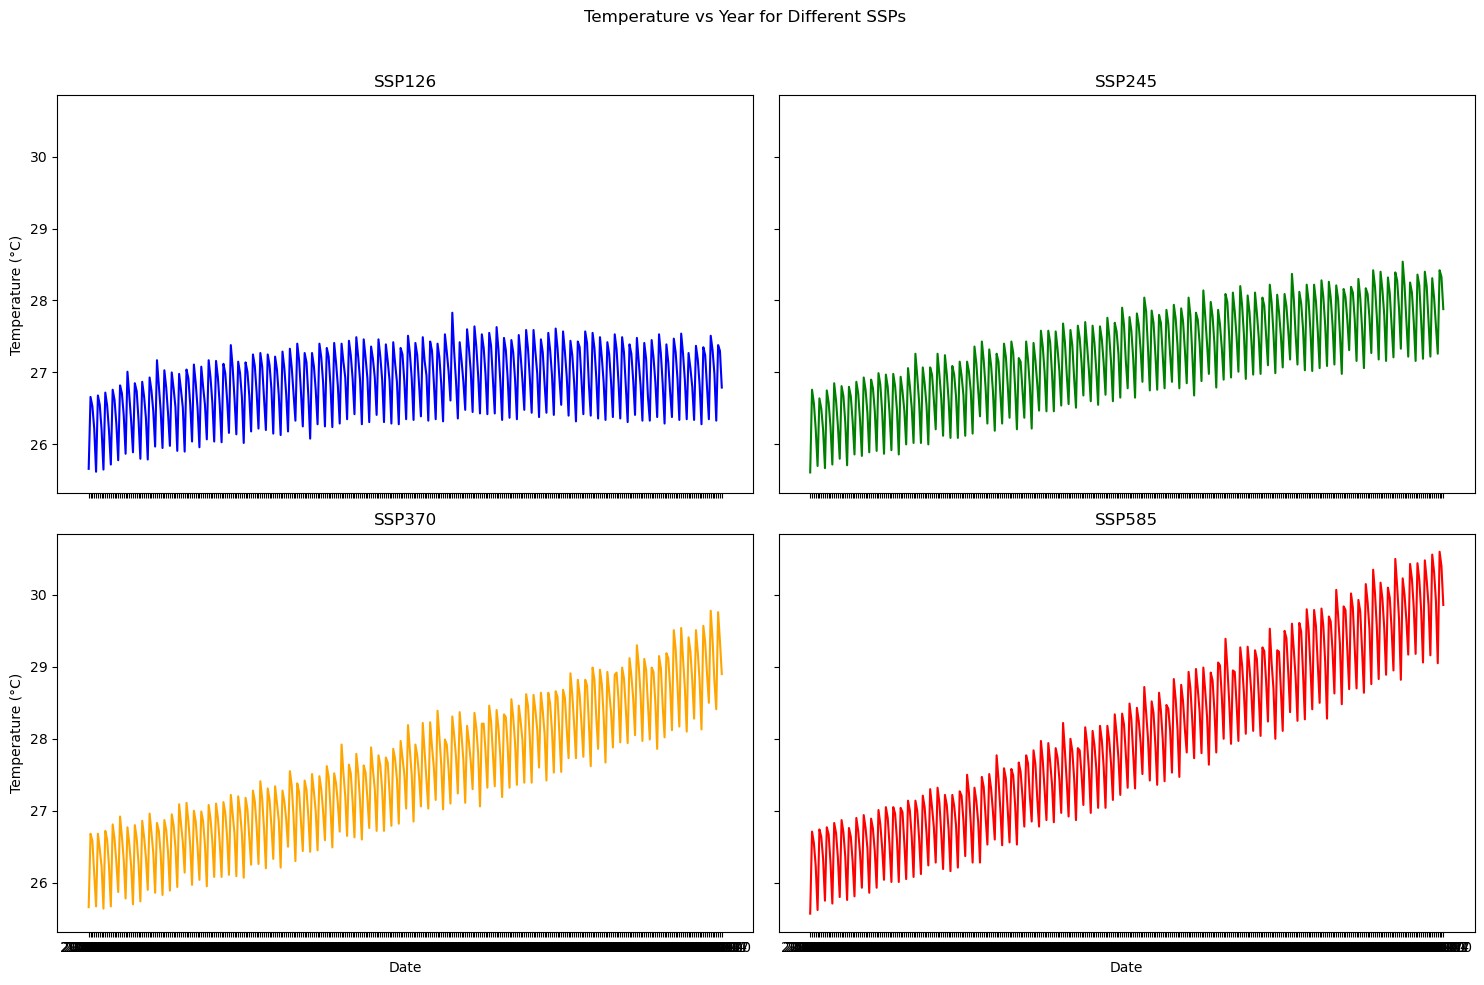

In [270]:
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Temperature vs Year for Different SSPs')

# Plot for SSP126
axes[0, 0].plot(ssp126_df['Date'], ssp126_df['tas'], label='SSP126', color='blue')
axes[0, 0].set_title('SSP126')
axes[0, 0].set_ylabel('Temperature (°C)')

# Plot for SSP245
axes[0, 1].plot(ssp245_df['Date'], ssp245_df['tas'], label='SSP245', color='green')
axes[0, 1].set_title('SSP245')

# Plot for SSP370
axes[1, 0].plot(ssp370_df['Date'], ssp370_df['tas'], label='SSP370', color='orange')
axes[1, 0].set_title('SSP370')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Temperature (°C)')

# Plot for SSP585
axes[1, 1].plot(ssp585_df['Date'], ssp585_df['tas'], label='SSP585', color='red')
axes[1, 1].set_title('SSP585')
axes[1, 1].set_xlabel('Date')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [238]:
# predict ffb yield for the next 20 years
model = joblib.load('ffb_yield_model.pkl')
X = ssp126_df[['pr', 'tas', 'hurs', 'Year', 'Month']]
ssp126_df['FFB_Yield'] = model.predict(X)
ssp126_df

,Year,Month,pr,tas,hurs,FFB_Yield
0,2015,1,328.05,25.66,81.06,1.5121
1,2015,4,658.11,26.66,81.06,1.4900
2,2015,7,563.51,26.53,80.91,1.5991
3,2015,10,838.11,26.22,82.53,1.7411
4,2016,1,697.43,25.62,82.11,1.5277
...,...,...,...,...,...,...
339,2099,10,852.11,26.98,82.37,1.7704
340,2100,1,698.19,26.33,81.61,1.4798
341,2100,4,687.92,27.38,80.73,1.4834
342,2100,7,634.20,27.30,81.19,1.6034


In [230]:
# # get data from 2015 to 2023
# ssp126 = pd.read_csv('ssp126_climate.csv')
# ssp126 = ssp126[(ssp126['Year'] >= 2015) & (ssp126['Year'] <= 2023)]

# # predict FFB yield, FFB production, and CPO yield using the best model
# model_ffb_yield = joblib.load('ffb_yield_model.pkl')
# X = ssp126[['pr', 'tas', 'hurs', 'Year', 'Month']]
# y = palm_oil[(palm_oil['Year'] >= 2015) & (palm_oil['Year'] <= 2023)]['FFB_Yield'] # get the actual FFB yield from 2015 to 2023

# #check if len of X and y are the same
# if len(X) != len(y):
#     raise ValueError('Length of X and y must be the same')

# y_pred = model_ffb_yield.predict(X)

# #evaluate the model
# rmse = root_mean_squared_error(y, y_pred)
# r2 = r2_score(y, y_pred)
# mae = mean_absolute_error(y, y_pred)

# print(f'RMSE: {rmse}')
# print(f'R2: {r2}')
# print(f'MAE: {mae}')

# y_pred = pd.DataFrame(y_pred, columns=['FFB_Yield_Predicted'])
# y_pred['FFB_Yield_Actual'] = y.values
# y_pred['Year'] = ssp126['Year']
# y_pred


In [231]:
# # create method to visualize the temperature, precipitation, and humidity data
# def visualize_climate_data(data, title):
#     fig, axes = plt.subplots(3, 1, figsize=(20, 15))
#     fig.suptitle(title)

#     for i, feature in enumerate(['pr', 'tas', 'hurs']):
#         data.plot(x='Year', y=feature, ax=axes[i], title=feature)
#         axes[i].set_ylabel(feature)
#         axes[i].set_xlabel('Year')
        
#     plt.tight_layout()
#     plt.show()

In [232]:
# # read ssp126 data
# import pandas as pd
# import matplotlib.pyplot as plt
# ssp126 = pd.read_csv('ssp126_climate.csv')
# visualize_climate_data(ssp126, 'SSP126 Climate Data')





### generate prediction

- select the current best models
- deploy models
- create prediction
- create streamlit app

by 22/12

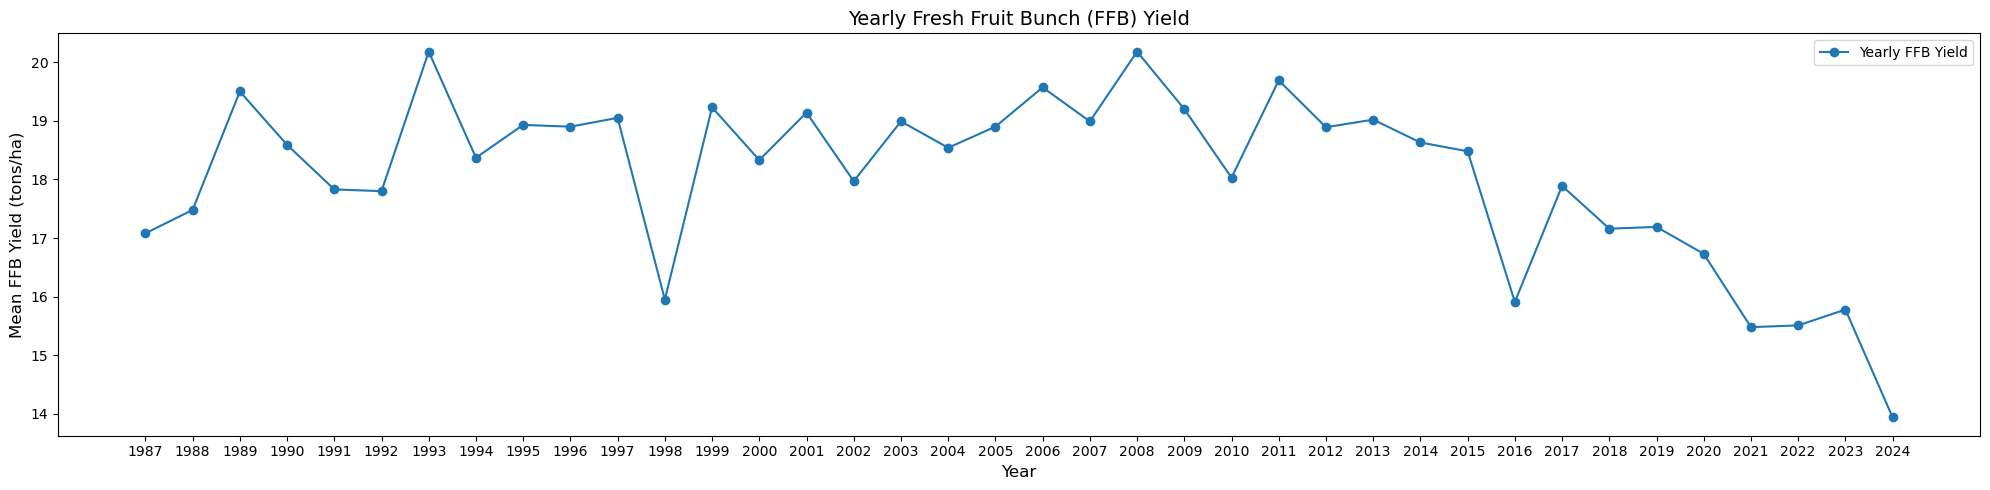

In [1]:
# visualise palm oil data as until 2015
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

palm_oil = pd.read_csv('palm_oil.csv')
yearly_yield = palm_oil.groupby('Year')['FFB_Yield'].sum().reset_index()

# Plot the yearly yield
plt.figure(figsize=(20, 5))
plt.plot(yearly_yield['Year'], yearly_yield['FFB_Yield'], marker='o', label='Yearly FFB Yield')

# Customize the plot
plt.title('Yearly Fresh Fruit Bunch (FFB) Yield', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean FFB Yield (tons/ha)', fontsize=12)
plt.xticks(yearly_yield['Year'])
plt.legend()
plt.tight_layout()


In [9]:
import joblib
import pandas as pd

# load the model
ffb_yield = joblib.load('ffb_yield_model.pkl')
cpo_yield = joblib.load('cpo_yield_model.pkl')

In [20]:
# get ssps data
ssp126_df = pd.read_csv('ssp126_climate.csv')
ssp245_df = pd.read_csv('ssp245_climate.csv')
ssp370_df = pd.read_csv('ssp370_climate.csv')
ssp585_df = pd.read_csv('ssp585_climate.csv')

ssp126_df['FFB_yeild_pred'] = ffb_yield.predict(ssp126_df[['pr', 'tas', 'hurs', 'Year', 'Month']])
ssp245_df['FFB_yeild_pred'] = ffb_yield.predict(ssp245_df[['pr', 'tas', 'hurs', 'Year', 'Month']])
ssp370_df['FFB_yeild_pred'] = ffb_yield.predict(ssp370_df[['pr', 'tas', 'hurs', 'Year', 'Month']])
ssp585_df['FFB_yeild_pred'] = ffb_yield.predict(ssp585_df[['pr', 'tas', 'hurs', 'Year', 'Month']])

# visualize the predicted FFB yield of the different SSPs
predictions = pd.concat([ssp126_df[['Year', 'Month', 'FFB_yeild_pred']], ssp245_df['FFB_yeild_pred'], ssp370_df['FFB_yeild_pred'], ssp585_df['FFB_yeild_pred']], axis=1)
predictions.columns = ['Year', 'Month', 'SSP126', 'SSP245', 'SSP370', 'SSP585']
predictions

,Year,Month,SSP126,SSP245,SSP370,SSP585
0,2015,1,1.5411,1.5449,1.5576,1.5226
1,2015,2,1.3483,1.2626,1.2521,1.3203
2,2015,3,1.3765,1.3613,1.3926,1.3382
3,2015,4,1.4660,1.4579,1.4731,1.4353
4,2015,5,1.5328,1.4306,1.4316,1.4357
...,...,...,...,...,...,...
1027,2100,8,1.8030,1.7868,1.8567,1.8312
1028,2100,9,1.9234,1.9362,1.9288,1.8547
1029,2100,10,1.8257,1.8555,1.8624,1.8769
1030,2100,11,1.8228,1.8686,1.7484,1.7484


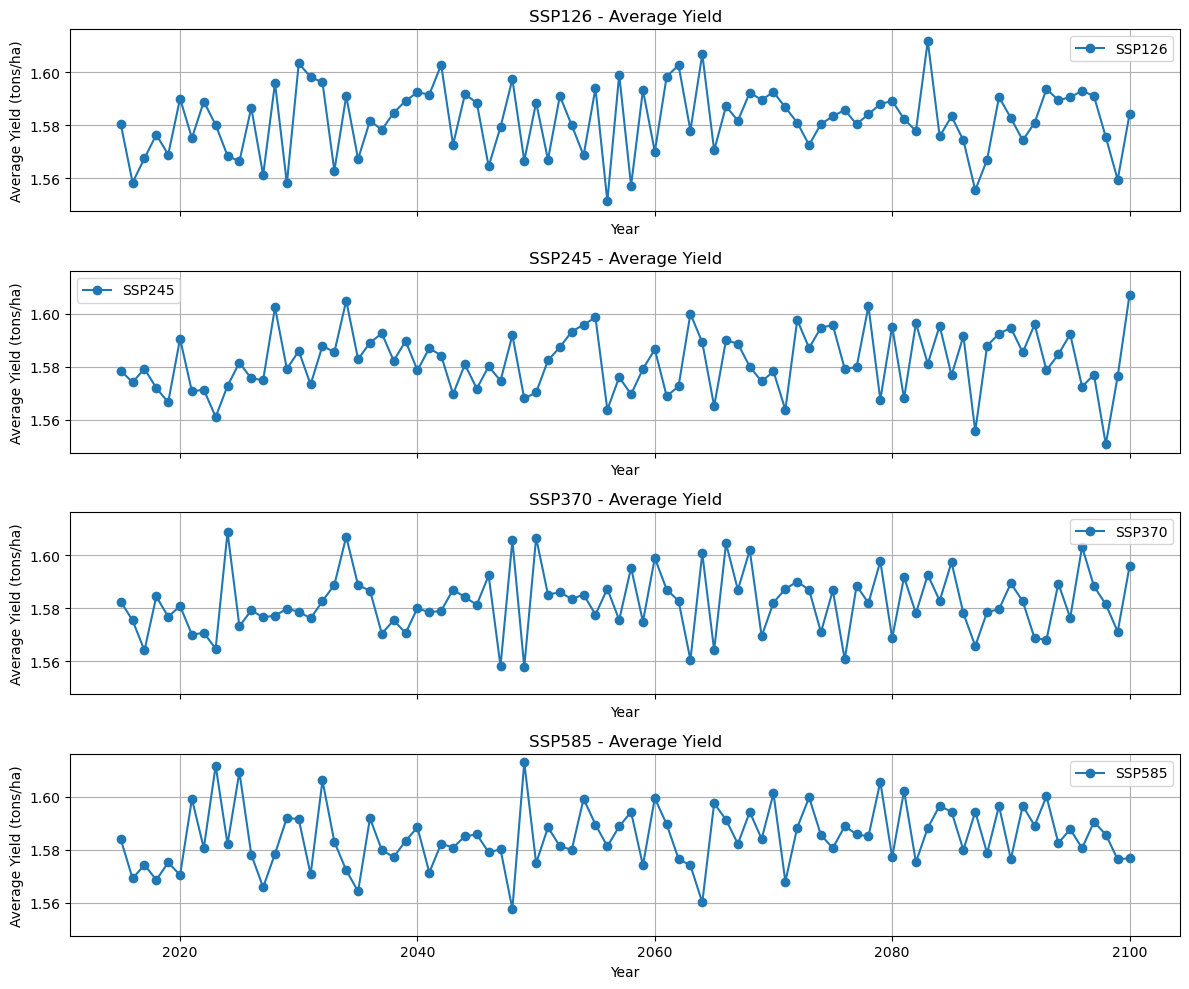

In [26]:
# visualize the predicted FFB yield of the different SSPs
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the dataframe
yearly_mean = predictions.groupby('Year').mean().reset_index()
ssp_columns = ['SSP126', 'SSP245', 'SSP370', 'SSP585']
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()


# Plot for each SSP
for i, ssp in enumerate(ssp_columns):
    axes[i].plot(yearly_mean['Year'], yearly_mean[ssp], marker='o', label=ssp)
    axes[i].set_title(f'{ssp} - Average Yield')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Average Yield (tons/ha)')
    axes[i].grid(True)
    axes[i].legend()

axes[-1].set_xlabel('Year')

# Adjust layout
plt.tight_layout()
plt.show()

In [38]:
import joblib
import pandas as pd

ffb_yield = joblib.load('ffb_yield_model.pkl')
# get ssps data
ssp126_df = pd.read_csv('ssp126_climate.csv')
ssp245_df = pd.read_csv('ssp245_climate.csv')
ssp370_df = pd.read_csv('ssp370_climate.csv')
ssp585_df = pd.read_csv('ssp585_climate.csv')

ssp126_df['FFB_yeild_pred'] = ffb_yield.predict(ssp126_df[['pr', 'tas', 'hurs', 'Year', 'Month']])
ssp245_df['FFB_yeild_pred'] = ffb_yield.predict(ssp245_df[['pr', 'tas', 'hurs', 'Year', 'Month']])
ssp370_df['FFB_yeild_pred'] = ffb_yield.predict(ssp370_df[['pr', 'tas', 'hurs', 'Year', 'Month']])
ssp585_df['FFB_yeild_pred'] = ffb_yield.predict(ssp585_df[['pr', 'tas', 'hurs', 'Year', 'Month']])

# visualize the predicted FFB yield of the different SSPs
predictions = pd.concat([ssp126_df[['Year', 'Month', 'FFB_yeild_pred']], ssp245_df['FFB_yeild_pred'], ssp370_df['FFB_yeild_pred'], ssp585_df['FFB_yeild_pred']], axis=1)
predictions.columns = ['Year', 'Month', 'SSP126', 'SSP245', 'SSP370', 'SSP585']
predictions.head()

,Year,Month,SSP126,SSP245,SSP370,SSP585
0,2015,1,1.5411,1.5449,1.5576,1.5226
1,2015,2,1.3483,1.2626,1.2521,1.3203
2,2015,3,1.3765,1.3613,1.3926,1.3382
3,2015,4,1.4660,1.4579,1.4731,1.4353
4,2015,5,1.5328,1.4306,1.4316,1.4357


In [39]:
# divide years into groups
bins = [2020, 2040, 2060, 2080, 2100]
labels = ['2020-2039', '2040-2059', '2060-2079', '2080-2099']

# map month to quarters
month_to_quarter = {
    1: 'Q1', 2: 'Q1', 3: 'Q1',
    4: 'Q2', 5: 'Q2', 6: 'Q2',
    7: 'Q3', 8: 'Q3', 9: 'Q3',
    10: 'Q4', 11: 'Q4', 12: 'Q4'
}

predictions['Quarter'] = predictions['Month'].map(month_to_quarter)
predictions['Year_Group'] = pd.cut(predictions['Year'], bins=bins, labels=labels, right=False)
predictions.to_csv('FFBpredictions.csv', index=False)

In [35]:
# melt the dataframe
melted_df = predictions.melt(
    id_vars=['Year', 'Month', 'Year_Group', 'Quarter'], 
    value_vars=['SSP126', 'SSP245', 'SSP370', 'SSP585'], 
    var_name='SSP Scenario', 
    value_name='FFB_Yield_Predicted')

# group by year group, quarter, and ssp scenario to caluclate the min, max, and mean yield
summary = (
    melted_df.groupby(['Year_Group', 'Quarter', 'SSP Scenario'])
    .agg(
        Min=('FFB_Yield_Predicted', 'min'),
        Mean=('FFB_Yield_Predicted', 'mean'),
        Max=('FFB_Yield_Predicted', 'max'))
    .reset_index()
)

C:\Users\Aqilah\AppData\Local\Temp\ipykernel_15084\315270609.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  melted_df.groupby(['Year_Group', 'Quarter', 'SSP Scenario'])


In [36]:
summary_pivot = summary.pivot(
    index= 'SSP Scenario',
    columns= ['Year_Group', 'Quarter'],
    values =['Min', 'Mean', 'Max'],
)

summary_pivot.columns = [' '.join(col).strip() for col in summary_pivot.columns]
summary_pivot.reset_index(inplace=True)

summary_pivot

,SSP Scenario,Min 2020-2039 Q1,Min 2020-2039 Q2,Min 2020-2039 Q3,Min 2020-2039 Q4,Min 2040-2059 Q1,Min 2040-2059 Q2,Min 2040-2059 Q3,Min 2040-2059 Q4,Min 2060-2079 Q1,...,Max 2040-2059 Q3,Max 2040-2059 Q4,Max 2060-2079 Q1,Max 2060-2079 Q2,Max 2060-2079 Q3,Max 2060-2079 Q4,Max 2080-2099 Q1,Max 2080-2099 Q2,Max 2080-2099 Q3,Max 2080-2099 Q4
0,SSP126,1.2804,1.3792,1.5678,1.5257,1.2881,1.3771,1.5694,1.5637,1.2760,...,1.9402,1.8947,1.4511,1.5468,1.9388,1.8765,1.4424,1.5475,1.9346,1.8879
1,SSP245,1.2867,1.3829,1.5646,1.4581,1.2856,1.3704,1.5669,1.5501,1.2832,...,1.9289,1.8972,1.4493,1.5514,1.9387,1.8791,1.4400,1.5447,1.9367,1.9084
2,SSP370,1.2710,1.3760,1.5689,1.4941,1.2749,1.3746,1.5746,1.5571,1.2746,...,1.9343,1.8906,1.4412,1.5558,1.9387,1.9078,1.4502,1.5445,1.9424,1.8801
3,SSP585,1.2864,1.3865,1.5657,1.5454,1.2693,1.3733,1.5706,1.5521,1.2897,...,1.9388,1.9283,1.4360,1.5347,1.9372,1.8940,1.4507,1.5465,1.9347,1.8942


# Prediction